Project: North Macedonia Procurment Network Analysis (2011-2022)  
Date: 30/1/2023  
Author: Aly Abdou   
Dataset: MK_202212_processed.csv (/08akkiGH/WB_MK/data/MK_202212_processed.csv.gz)

### Resource
[Social Network Analysis: From Graph Theory to Applications with Python](https://towardsdatascience.com/social-network-analysis-from-theory-to-applications-with-python-d12e9a34c2c7)

Based mainly on the [WB Bulgaria work](https://docs.google.com/document/d/1GzLs9eOVHVYPXocngLi7l___rn85k3wM/edit?rtpof=true&sd=true) 

### To do
1) Set up dataset -  add regions, markets, identify main variables to be used etc. [done]  
2) Add python functions to plot the network    
3) Modularity groups - Membership algorithim [done]  
4) Added functions to process data and get descriptive network stats for filtered datasets [done]  
5) Community detection  


In [2]:
pip install networkx

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 17.8 MB/s eta 0:00:0031m16.7 MB/s eta 0:00:01

[notice] A new release of pip is available: 23.3.1 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


### Import

In [35]:
import os
import pandas as pd
import numpy as np
import time
import networkx as nx
from networkx.algorithms import community
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
# import pymaterial
import scipy.stats as stats


In [4]:
os.chdir("/home/aly/Desktop/Misc/WB_MK_figures")

### Data Preperation

In [ ]:
# Load Dataset
# pp_data = pd.read_csv(f'data/processed/MK_202212_processed.csv', encoding="utf-8",
#                       dtype={'buyer_id': str, 'bidder_id': str})
pp_data = pd.read_csv(f'data/processed/MK_202303_processed.csv', encoding="utf-8",
                      dtype={'buyer_id': str, 'bidder_id': str})

# Variable addition and selection
# Filter variables
cols = ['tender_id','buyer_id','buyer_name','bidder_name','bidder_id','year','month','bid_price',
        'tender_cpvs','tender_supplytype','buyer_nuts','cri','filter_ok']
pp_data = pp_data[cols]


# Create market 
pp_data['market'] = pp_data['tender_cpvs'].str[:2]


pp_data['buyer_loc'] = pp_data['buyer_nuts'].replace({
    'MK001': 'Vardarski',
    'MK002': 'Istočen',
    'MK003': 'Jugozapaden',
    'MK004': 'Jugoistočen',
    'MK005': 'Pelagoniski',
    'MK006': 'Pološki',
    'MK007': 'Severoistočen',
    'MK008': 'Skopski',
})

#Apply filter_ok
pp_data = pp_data[pp_data["filter_ok"] == 1]

# Drop missing buyer id and buyer_nuts
pp_data = pp_data.dropna(subset=['buyer_id'])
pp_data = pp_data.dropna(subset=['buyer_nuts'])
pp_data = pp_data.dropna(subset=['year'])

# Replace node id to B_ and S_
pp_data["buyer_id"] = "B_"+ pp_data["buyer_id"] 
pp_data["bidder_id"] = "S_"+ pp_data["bidder_id"] 

pp_data['year'] = pp_data['year'].round().astype(int).astype(str)


# pp_data.isnull().sum()

In [ ]:
pp_markets = pp_data[['market','bid_price']]
pp_markets['totals'] = pp_markets.groupby('market')['bid_price'].transform('sum')
pp_markets = pp_markets.drop_duplicates(['market','totals'], keep='first')
pp_markets = pp_markets[['market','totals']]
pp_markets.sort_values('totals')
pp_markets
# pp_markets.groupby(['totals']).size().sort_values()

In [ ]:
pp_data['year'].unique()

In [ ]:
len(pp_data)

In [ ]:
# pp_data = pp_data.sample(10000)
pp_data_const = pp_data[pp_data['market'] == '45']


In [ ]:
pp_data_processed = process_data(pp_data)

In [ ]:
edgelist_vars = ['buyer_id','bidder_id','buyer_contracts', 'bidder_contracts', 'edge_contracts',
         'buyer_cri', 'bidder_cri', 'edge_cri',
         'buyer_tot_value', 'bidder_tot_value', 'edge_tot_value']
edgelist = pp_data_processed[edgelist_vars]

edgelist = edgelist.sort_values(['buyer_id','bidder_id']).drop_duplicates(['buyer_id','bidder_id'], keep='first')

In [ ]:
len(edgelist)

In [ ]:
pp_data_processed
pp_data_processed['bid_price'].sum()
# 511,588,557,092.0

In [ ]:
3.04E+08

In [ ]:
3.04E+08

In [ ]:
len(pp_data_processed['market'].unique())
# pp_data_processed['market'].unique()

In [ ]:
len(pp_data_before_long)
print(pp_data_before_long['bid_price'].sum())
print(pp_data_after_long['bid_price'].sum())



pp_data_before_long = process_data(pp_data_before_long)
pp_data_after_long = process_data(pp_data_after_long)

edgelist_vars = ['buyer_id','bidder_id','buyer_contracts', 'bidder_contracts', 'edge_contracts',
         'buyer_cri', 'bidder_cri', 'edge_cri',
         'buyer_tot_value', 'bidder_tot_value', 'edge_tot_value']

edgelist_before = pp_data_before_long[edgelist_vars]

edgelist_after = pp_data_after_long[edgelist_vars]

edgelist_before = edgelist_before.sort_values(['buyer_id','bidder_id']).drop_duplicates(['buyer_id','bidder_id'], keep='first')
edgelist_after = edgelist_after.sort_values(['buyer_id','bidder_id']).drop_duplicates(['buyer_id','bidder_id'], keep='first')



In [ ]:
print('Before')
print(len(edgelist_before['buyer_id'].unique()))
print(len(edgelist_before['bidder_id'].unique()))

print('After')
print(len(edgelist_after['buyer_id'].unique()))
print(len(edgelist_after['bidder_id'].unique()))

In [ ]:
def process_data(df):
    df_wip = df
    # Genrate total contract counts
    df_wip = df_wip.drop(df_wip.filter(regex='_contracts.*').columns, axis=1)
    df_wip = df_wip.merge(df_wip.groupby('buyer_id').size().reset_index(name='buyer_contracts'),
                        on='buyer_id', how='left')
    df_wip = df_wip.merge(df_wip.groupby('bidder_id').size().reset_index(name='bidder_contracts'),
                        on='bidder_id', how='left')
    df_wip["edge_id"] = df_wip['buyer_id'] +"-"+ df_wip["bidder_id"]
    df_wip = df_wip.merge(df_wip.groupby('edge_id').size().reset_index(name='edge_contracts'),
                        on='edge_id', how='left')

    # Generate Average CRI values
    df_wip['buyer_cri'] = df_wip.groupby('buyer_id')['cri'].transform('mean')
    df_wip['bidder_cri'] = df_wip.groupby('bidder_id')['cri'].transform('mean')
    df_wip['edge_cri'] = df_wip.groupby(['buyer_id', 'bidder_id'])['cri'].transform('mean')

    # Generate Average total values
    df_wip['buyer_tot_value'] = df_wip.groupby('buyer_id')['bid_price'].transform('sum')
    df_wip['bidder_tot_value'] = df_wip.groupby('bidder_id')['bid_price'].transform('sum')
    df_wip['edge_tot_value'] = df_wip.groupby(['buyer_id', 'bidder_id'])['bid_price'].transform('sum')
    
    df_wip.reset_index()
    # Keep only the created variables
    keep_vars = ['buyer_id','bidder_id','year','market','tender_supplytype','buyer_loc',
                 'buyer_contracts', 'bidder_contracts', 'edge_contracts',
                 'buyer_cri', 'bidder_cri', 'edge_cri',
                 'buyer_tot_value', 'bidder_tot_value', 'edge_tot_value','bid_price']
    return df_wip[keep_vars]

In [ ]:
# print(edgelist_global.describe())
# xx.dtypes

# for i in xx.columns:
# #     if pp_data[i].dtype == 'float':
#     value_counts = xx[i].value_counts()
#     print("Value counts for column", i, ":")
#     print(value_counts)
#     unique_count = xx[i].nunique()
#     print("Unique count for column", i, ":")
#     print(unique_count)
#     print("\n")
# len(xx)
# print(xx.columns)

# Descriptives
# pp_data['count_hist'] = pp_data[(pp_data['count'] >= 0) & (pp_data['count'] <= 100)]['count']
# pp_data['count_hist'].plot.hist(bins=50)
# plt.show()
# pp_data['count'].describe()

In [ ]:
# xx.reset_index()
# xx[(xx["buyer_id"] == '99') ]
# xx[(xx["buyer_id"] == '99') & (xx["bidder_id"] == '7546')]

# edgelist_test = edgelist.sample(n=500)
# edgelist_test

### Create Graph

In [ ]:
def create_graph(edgelist):
    # Create a DataFrame for the source nodes
    buyers = edgelist[['buyer_id', 'buyer_contracts', 'buyer_cri', 'buyer_tot_value']]
    buyers = buyers.drop_duplicates()
    buyers = buyers.rename(columns={'buyer_id': 'node_id',
                                    'buyer_contracts': 'contracts',
                                    'buyer_cri': 'cri',
                                    'buyer_tot_value': 'tot_value'})

    # Create a DataFrame for the target nodes
    bidders = edgelist[['bidder_id', 'bidder_contracts', 'bidder_cri', 'bidder_tot_value']]
    bidders = bidders.drop_duplicates()
    bidders = bidders.rename(columns={'bidder_id': 'node_id',
                                      'bidder_contracts': 'contracts',
                                      'bidder_cri': 'cri',
                                      'bidder_tot_value': 'tot_value'})

    # Concatenate the two DataFrames
    nodes = pd.concat([buyers, bidders], ignore_index=True)
    
    # Create the graph
    G = nx.from_pandas_edgelist(edgelist,
                                source='buyer_id',
                                target='bidder_id',
                                edge_attr=['edge_contracts', 'edge_cri', 'edge_tot_value'],
                                create_using=nx.Graph())
    
    # Add node attributes to the graph
    nx.set_node_attributes(G, nodes.set_index('node_id').to_dict('index'))
    
    return G

In [ ]:
def get_graph_statistics(G, name):
    statistics = {}

    # Graph name
    statistics["Name"] = name
    
    # Number of nodes
    statistics["Number of nodes"] = G.number_of_nodes()
    
    # Number of edges
    statistics["Number of edges"] = G.number_of_edges()
    
    # Average degree
    try:
        avg_degree = sum(d for n, d in G.degree()) / statistics["Number of nodes"]
        statistics["Average degree"] = avg_degree
    except:
        statistics["Average degree"] = ''
    
#     # Diameter % Radius
#     try:
#         statistics["Diameter"] = nx.diameter(G)
#         statistics["Radius"] = nx.radius(G)
#     except:
#         largest_cc = max(nx.connected_components(G), key=len)
#         largest_cc_graph = G.subgraph(largest_cc)
#         statistics["Diameter"] = nx.diameter(largest_cc_graph)
#         statistics["Radius"] = nx.radius(largest_cc_graph)
    
#     # Average clustering coefficient
#     statistics["Average clustering coefficient"] = nx.average_clustering(G)
    
#     # Transitivity
#     statistics["Transitivity"] = nx.transitivity(G)
    
    # Assortativity
    statistics["Assortativity"] = nx.degree_assortativity_coefficient(G)
    
    # Average Degree centrality
    degree_centrality = nx.degree_centrality(G)
    try:
        avg_degree_centrality = sum(degree_centrality.values()) / len(degree_centrality)
        statistics["Average degree centrality"] = avg_degree_centrality
    except:
         statistics["Average degree centrality"] = ''
    
    # Average Closeness centrality
    closeness_centrality = nx.closeness_centrality(G)
    try:
        avg_closeness_centrality = sum(closeness_centrality.values()) / len(closeness_centrality)
        statistics["Average closeness centrality"] = avg_closeness_centrality
    except:
        statistics["Average closeness centrality"] = ''
    
    # Average betweenness centrality
    betweenness_centrality = nx.betweenness_centrality(G, weight = 'edge_cri')
    try:
        avg_betweenness_centrality = sum(betweenness_centrality.values()) / len(betweenness_centrality)
        statistics["Average betweenness centrality"] = avg_betweenness_centrality
    except:
        statistics["Average betweenness centrality"] = ''

#     # Average eigenvector centrality
#     try:
#         eigenvector_centrality = nx.eigenvector_centrality(G)
#         avg_eigenvector_centrality = sum(eigenvector_centrality.values()) / len(eigenvector_centrality)
#         statistics["Average eigenvector centrality"] = avg_eigenvector_centrality
#     else:
#         statistics["Average eigenvector centrality"] = 'Failed'
        
    # Graph modularity
    communities = nx.algorithms.community.modularity_max.greedy_modularity_communities(G)
    modularity = nx.algorithms.community.quality.modularity(G, communities)
    statistics["Modularity Greedy"] = modularity
    avg_modularity = nx.algorithms.community.quality.modularity(G, communities) / G.number_of_nodes()
    statistics["Norm. modularity Greedy"] = avg_modularity
    
    # Louvain Modularity
    communities = nx.algorithms.community.louvain_communities(G, weight = 'edge_cri',seed=123)
    modularity = nx.algorithms.community.quality.modularity(G, communities)
    statistics["Modularity Louvain"] = modularity
    avg_modularity = nx.algorithms.community.quality.modularity(G, communities) / G.number_of_nodes()
    statistics["Norm. modularity Louvain"] = avg_modularity
    
    return statistics

In [ ]:
def main_analysis_process(df, name):
    
    edgelist_vars = ['buyer_id','bidder_id','buyer_contracts', 'bidder_contracts', 'edge_contracts',
             'buyer_cri', 'bidder_cri', 'edge_cri',
             'buyer_tot_value', 'bidder_tot_value', 'edge_tot_value']
    
    # Process the data
    df_processed = process_data(df)

    # Create edge list
    edgelist = df_processed[edgelist_vars]
    edgelist = edgelist.sort_values(['buyer_id','bidder_id']).drop_duplicates(['buyer_id','bidder_id'], keep='first')

    # Edgelist Statisitcs
    c=pd.DataFrame(edgelist.describe())
    c['graph'] = name

    if os.path.isfile('output/tables/Networks/desc_edgelist.csv'):
        c.to_csv(f'output/tables/Networks/desc_edgelist.csv', index = True, mode='a', header=False)
    else:
        c.to_csv(f'output/tables/Networks/desc_edgelist.csv', index = True, mode='w', header=True)

    # Create Graph
    graph_statistics = []
    G = create_graph(edgelist)
    if G.number_of_nodes()>0:
        graph_statistics.append(get_graph_statistics(G, name))

    # Graph Statisitcs
    graph_statistics_df = pd.DataFrame(graph_statistics)
    graph_statistics_df = graph_statistics_df.drop_duplicates()
    
    if os.path.isfile('output/tables/Networks/desc_graph.csv'):
        graph_statistics_df.to_csv(f'output/tables/Networks/desc_graph.csv', index = False, mode='a', header=False)
    else:
        graph_statistics_df.to_csv(f'output/tables/Networks/desc_graph.csv', index = False, mode='w', header=True)
        
    
    return df_processed, edgelist, G

### Network Data Descriptives

In [ ]:
# Filter data if needed 
filter_vars = ['year','market','tender_supplytype','buyer_loc']

# Runmain_analysis_process to get procurment data [contracts], modified edgelist, Graph object + Descriptive tables
start = time.time()
pp_data_global, edgelist_global, G_global = main_analysis_process(pp_data, 'Global')
end = time.time()
print("Time taken:", end - start, "seconds")


What is Modularirty?  
A modularity score close to 1 indicates a strong community structure, where nodes are densely connected within  
communities and sparsely connected between communities. A score close to 0 indicates a weak community structure,  
where there are no clear communities in the network. A negative score indicates that the network has a community  
structure that is worse than a random network with the same number of nodes and edges.

In [ ]:
# pp_data = pp_data.sample(5000

#### Yearly outputs

In [ ]:
filter_var = 'year'
years = pp_data[filter_var].unique()

start = time.time()
for year in years:
    pp_data_filtered = pp_data[pp_data[filter_var] == year]
    pp_data_year, edgelist_year, G_year = main_analysis_process(pp_data_filtered, year)
    exec(f"pp_data_{filter_var}_{year} = pp_data_year")
    exec(f"edgelist_{filter_var}_{year} = edgelist_year")
    exec(f"G_{filter_var}_{year} = G_year")
    
end = time.time()
print("Time taken:", end - start, "seconds")

In [ ]:
years
# G_year_2019

#### Regional outputs

In [ ]:
filter_var = 'buyer_loc'
regions = pp_data[filter_var].unique()


start = time.time()
for region in regions:
    pp_data_filtered = pp_data[pp_data[filter_var] == region]
    pp_data_region, edgelist_region, G_region = main_analysis_process(pp_data_filtered, region)
    exec(f"pp_data_{filter_var}_{region} = pp_data_region")
    exec(f"edgelist_{filter_var}_{region} = edgelist_region")
    exec(f"G_{filter_var}_{region} = G_region")
end = time.time()
print("Time taken:", end - start, "seconds")


In [ ]:
regions 
# G_buyer_loc_Jugoistočen

##### Save Graphs and edgelists on disk

In [ ]:
# Write outputs to disk
nx.write_graphml(G_global, 'data/processed/Networks/graphs/G_global.graphml')
edgelist_global.to_csv(f'data/processed/Networks/edgelists/edgelist_global.csv', index = False, header=True)

filter_var = 'year'
years = pp_data[filter_var].unique()
for year in years:
    # Load the graph for the current year
    G_year = eval(f'G_{filter_var}_{year}')
    # Save the graph
    nx.write_graphml(G_year, f'data/processed/Networks/graphs/G_{filter_var}_{year}.graphml')
    # Load the edgelist for the current year
    edgelist_year = eval(f'edgelist_{filter_var}_{year}')
    # Save the edgelist
    edgelist_year.to_csv(f'data/processed/Networks/edgelists/edgelist_{filter_var}_{year}.csv', index = False, header=True)

filter_var = 'buyer_loc'
regions = pp_data[filter_var].unique()
for region in regions:
    # Load the graph for the current year
    G_region = eval(f'G_{filter_var}_{region}')
    # Save the graph
    nx.write_graphml(G_region, f'data/processed/Networks/graphs/G_{filter_var}_{region}.graphml')
    # Load the edgelist for the current region
    edgelist_region = eval(f'edgelist_{filter_var}_{region}')
    # Save the edgelist
    edgelist_region.to_csv(f'data/processed/Networks/edgelists/edgelist_{filter_var}_{region}.csv', index = False, header=True)


#### Load Graphs

In [ ]:
loaded_graph = nx.read_graphml( f'data/processed/Networks/graphs/G_buyer_loc_Severoistočen.graphml')

    
# if nx.is_isomorphic(G_buyer_loc_Severoistočen, loaded_graph):
if nx.fast_could_be_isomorphic(G_buyer_loc_Severoistočen, loaded_graph):
    print("The graphs are identical.")
else:
    print("The graphs are not identical.")


In [ ]:
G_buyer_loc_Severoistočen

### Plot Graph

In [ ]:
def plot_graph(G_str):
    
    # Graph name
    G = eval(f'{G_str}')
    name = G_str
    print(name)
    
    # Largest connected component
    Gc = max(nx.connected_components(G), key=len)
    # Filter one degree nodes
    Gc = nx.subgraph(G, [node for node in Gc if G.degree[node] > 1])

    # # Filter out the edges between a range of cri values
    Gc = nx.Graph(Gc)
    edge_cri_values = [d['edge_cri'] for u,v,d in Gc.edges(data=True)]
    first_quantile = np.quantile(edge_cri_values, 0.01)
    last_quantile = np.quantile(edge_cri_values, 0.99)
    Gc.remove_edges_from([(u,v) for (u,v,d) in Gc.edges(data=True) if (d['edge_cri'] < first_quantile or d['edge_cri'] > last_quantile)])

    # Plotting 
    # for node, data in G.nodes(data=True):
    #     print(f'Node: {node}')
    #     for key, value in data.items():
    #         print(f'\t{key}: {value}')

    # Node size = contract number 
    node_sizes = [d['contracts'] for n, d in Gc.nodes(data=True)]

    # Node colors
    source_nodes = [node for node in Gc.nodes() if node.startswith('B_')]
    color_map = {}
    for node in Gc.nodes():
        if node in source_nodes:
            color_map[node] = 'blue'
        else:
            color_map[node] = 'yellow'

    # Edge Colors
    edge_colors = [Gc[u][v]['edge_cri'] for u, v in Gc.edges()]

    # Edge width - is edge edge_tot_value 
    edge_widths = [Gc[u][v]['edge_tot_value'] for u, v in Gc.edges()]
    
    # Layout
    plt.figure(figsize=(12,12))
    pos = nx.fruchterman_reingold_layout(Gc, scale=12, iterations=10, k=20, weight='edge_cri'*1000)

    nx.draw_networkx_nodes(Gc, pos, node_size=node_sizes, node_color=[color_map[node] for node in Gc.nodes()], node_shape='o')
    nx.draw_networkx_edges(Gc, pos, edge_color=edge_colors, edge_cmap=plt.cm.coolwarm, width=edge_widths)

    plt.axis('off')
    plt.box(False)
    # plt.show()
    plt.savefig(f'output/figures/Network_figures/{name}.png', dpi=300, bbox_inches='tight')


In [ ]:
# plot_graph('G_buyer_loc_Severoistočen')

In [ ]:
# Plot All graphs
filter_vars = ['year','buyer_loc']
for filter_var in filter_vars:
    values = pp_data[filter_var].unique()
    for value in values:
#         print(f'G_{filter_var}_{value}')
        plot_graph(f'G_{filter_var}_{value}')
    
plot_graph(f'G_global')

#### All Years

In [ ]:
import matplotlib.image as mpimg

# List of PNG files to load
file_list = []
for year in range(2011, 2023):
    file = f'output/figures/Network_figures/G_year_{year}.png'
    file_list.append(file)    
    
fig, axs = plt.subplots(4, 3, figsize=(100, 50))
axs = axs.ravel()
year = 2011
for i, file in enumerate(file_list):
    img = mpimg.imread(file)
    axs[i].imshow(img)
    axs[i].axis('off')
    axs[i].set_title(f"Year {year}", fontsize=100)
    year = year + 1
fig.tight_layout()
# plt.show()
plt.savefig(f'output/figures/Network_figures/G_all_years.png', dpi=300, bbox_inches='tight')


#### All Regions

In [ ]:
import re

# List of PNG files to load
file_list = []
regions = pp_data[filter_var].unique()
for region in regions:
    file = f'output/figures/Network_figures/G_buyer_loc_{region}.png'
    file_list.append(file)    

fig, axs = plt.subplots(2, 4, figsize=(100, 50))
axs = axs.ravel()
for i, file in enumerate(file_list):
    region = file.replace('output/figures/Network_figures/G_buyer_loc_', '')
    region = region.replace('.png', '')
    img = mpimg.imread(file)
    axs[i].imshow(img)
    axs[i].axis('off')
    axs[i].set_title(f"{region}", fontsize=100)
fig.tight_layout()
# plt.show()
plt.savefig(f'output/figures/Network_figures/G_all_regions.png', dpi=300, bbox_inches='tight')


#### Network region stats over time  

In [ ]:
# Each region split over years and get stats to plot in a line plot 

regions = pp_data['buyer_loc'].unique()

start = time.time()
for region in regions:
    pp_data_filtered_region = pp_data[pp_data['buyer_loc'] == region]
    years = pp_data_filtered_region['year'].unique()
    for year in years:
        pp_data_filtered = pp_data_filtered_region[pp_data_filtered_region['year'] == f'{year}']
        name  = f'{region}_{year}'
#         print(name)
#         print(len(pp_data_filtered))
        pp_data_result, edgelist_result, G_result = main_analysis_process(pp_data_filtered, name)
        exec(f"pp_data_{region}_{year} = pp_data_result")
        exec(f"edgelist_{region}_{year} = edgelist_result")
        exec(f"G_{region}_{year} = G_result")
        
        # Save the graph
        nx.write_graphml(G_result, f'data/processed/Networks/graphs/G_{region}_{year}.graphml')
        # Save the edgelist
        edgelist_result.to_csv(f'data/processed/Networks/edgelists/edgelist_{region}_{year}.csv', index = False, header=True)

end = time.time()
print("Time taken:", end - start, "seconds")

#### Region - Year line plots - Graph statistics 

In [ ]:
# Load graph descriptives
desc = pd.read_csv(f'output/tables/Networks/desc_graph.csv', encoding="utf-8")
desc[['region', 'year']] = desc['Name'].str.split('_', expand=True)
desc['year'] = desc['year'].astype(int)
# Convert "year" column to datetime format
desc['year'] = pd.to_datetime(desc['year'], format='%Y')

plots  = ['Number of nodes', 'Number of edges', 'Average degree',
          'Assortativity', 'Average degree centrality','Average closeness centrality',
          'Average betweenness centrality', 'Norm. modularity Greedy','Norm. modularity Louvain']

for col in plots:
    desc = desc.sort_values(by="year")
    fig, ax = plt.subplots()
    for region in desc['region'].unique():
        ax.plot(desc[desc['region'] == region]['year'], desc[desc['region'] == region][col], label=region)
    ax.legend()
    ax.set_xlabel('Year')
    ax.set_ylabel(col)
    legend = ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)
    plt.savefig(f'output/figures/Network_figures/Region_year_{col}.png', dpi=300, bbox_inches='tight')

fig, axs = plt.subplots(3, 3, figsize=(100, 50))
file_list = []
for col in plots:
    file = f'output/figures/Network_figures/Region_year_{col}.png'
    file_list.append(file)    
    
axs = axs.ravel()
for i, file in enumerate(file_list):
    img = mpimg.imread(file)
    axs[i].imshow(img)
    axs[i].axis('off')
    axs[i].legend('off')
    name = plots[i]
    axs[i].set_title(name, fontsize=100)
fig.tight_layout()
# plt.show()
plt.savefig(f'output/figures/Network_figures/Region_Year.png', dpi=300, bbox_inches='tight')
    

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image

df = desc.copy()
plots = ['Number of nodes', 'Number of edges', 'Average degree', 'Assortativity', 'Average degree centrality', 'Average closeness centrality', 'Average betweenness centrality', 'Norm. modularity Greedy', 'Norm. modularity Louvain']
fig, axs = plt.subplots(3, 3, figsize=(100, 50))
fig.tight_layout()
fig.set_constrained_layout(True)
# fix margins 
# fig.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.4, hspace=0.4)

axes = {(i, j): axs[i, j] for i in range(3) for j in range(3)}
df = df.set_index(['year', 'region'])
for i, p in enumerate(plots):
    row, col = divmod(i, 3)
    df[p].unstack().plot(ax=axes[(row, col)], legend=False, lw=8)
    axes[(row, col)].set_xlabel('Year', fontsize=60)
    axes[(row, col)].set_ylabel(p, fontsize=60)
fig.legend(df.index.levels[1], loc='lower center', ncol=(len(df.index.levels[1]))/2, fontsize=90)

# Save the first plot to a file
plt.savefig('output/figures/Network_figures/plot1.png', bbox_inches='tight')
# Clear the plot
plt.clf()
# Load the saved plot as an image
img = Image.open('output/figures/Network_figures/plot1.png')
# Add the loaded image to a new plot
fig, axs = plt.subplots(1, 1, figsize=(10, 10))
axs.imshow(img)
axs.axis('off')
# Display the new plot
plt.show()

### Cut off in May 2017 - when VMRO-DPMNE (incumbent) loses power 


In [ ]:
#Filter df based on cutoff 
pp_data['year'] = pp_data['year'].astype(int)
pp_data['month'] = pp_data['month'].astype(int)

pp_data['date'] = pd.to_datetime(pp_data['year'].astype(str) + '-' + pp_data['month'].astype(str), format='%Y-%m')

# Before Period Jan 2012 - Apr 2017 (5 years)
pp_data_before_long = pp_data[ (pp_data["year"] >= 2012) & (pp_data["year"] <= 2017) & (pp_data["date"] < pd.to_datetime('2017-05-01'))]

# After Period May 2017 - Dec 2022 (5 years)
pp_data_after_long = pp_data[(pp_data["year"] >= 2017) & (pp_data["date"] >= pd.to_datetime('2017-05-01'))]

# Before Period Jan 2015 - Apr 2017 (2 years)
pp_data_before_short = pp_data[ (pp_data["year"] >= 2015) & (pp_data["year"] <= 2017) & (pp_data["date"] < pd.to_datetime('2017-05-01'))]

# After Period May 2017 - Dec 2019 (2 years)
pp_data_after_short = pp_data[ (pp_data["year"] >= 2017) & (pp_data["year"] <= 2019) & (pp_data["date"] >= pd.to_datetime('2017-05-01'))]


In [ ]:
time = ['before', 'after']
comparison = ['long','short']

for t in time:
    for comp in comparison:
        print(t,comp)
        exec(f"pp_data = pp_data_{t}_{comp}")
        name = t+'_'+comp
        pp_data_result, edgelist_result, G_result = main_analysis_process(pp_data, name)
        nx.write_graphml(G_result, f'data/processed/Networks/graphs/G_{t}_{comp}.graphml')
        edgelist_result.to_csv(f'data/processed/Networks/edgelists/edgelist_{t}_{comp}.csv', index = False, header=True)
        exec(f"pp_data_out_{t}_{comp} = pp_data_result")
        exec(f"edgelist_{t}_{comp} = edgelist_result")
        exec(f"G_{t}_{comp} = G_result")
        plot_graph(f'G_{t}_{comp}')


The closeness centrality measures how quickly a node can reach all other nodes in the network. On the other hand, betweenness centrality measures how often a node appears on the shortest path between pairs of nodes.

Based on the given information, we can conclude that the nodes in G1 are on average closer to all other nodes compared to the nodes in G2, while the nodes in G2 are on average more likely to be on the shortest path between pairs of nodes than the nodes in G1.

The difference in average centrality values could indicate that the two graphs have different structures. For example, G1 may be a more densely connected network where nodes are generally close to each other, while G2 may have more long-range connections or hubs that are critical for connecting different parts of the network.

In summary, the difference in average centrality values suggests that the two graphs have different properties and structures, and further analysis would be required to understand these differences in more detail.

Global: This network has the highest number of nodes and edges compared to the other networks. It has an average degree of 10.21, which is the lowest among the networks. The assortativity coefficient is negative, indicating that nodes with high degree are more likely to be connected to nodes with low degree. The average degree centrality and closeness centrality values are the lowest among the networks, while the betweenness centrality value is the highest. The modularity values are also the highest among the networks, suggesting that the network can be divided into distinct communities or modules.

before_long: This network has a lower number of nodes and edges compared to the global network. It has a slightly lower average degree of 8.45 and a negative assortativity coefficient, indicating that nodes with high degree are more likely to be connected to nodes with low degree. The average degree centrality and closeness centrality values are also slightly lower compared to the global network, while the betweenness centrality value is slightly higher. The modularity values are also lower than the global network, indicating that the network is less modular or has fewer distinct communities.

after_long: This network has a lower number of nodes and edges compared to the global network but has a higher average degree of 13.5. It has a negative assortativity coefficient similar to the other networks. The average degree centrality, closeness centrality, and betweenness centrality values are all higher than the other networks, indicating that the nodes in this network are more central and important. The modularity values are slightly higher compared to the before_long network, suggesting that this network can be divided into more distinct communities.

If one graph has higher degree and closeness centrality and lower betweenness centrality compared to another graph, it suggests that the first graph has a more centralized and densely connected structure compared to the second graph.
Higher degree centrality implies that the nodes in the first graph have more direct connections to other nodes compared to the nodes in the second graph.
Higher closeness centrality implies that the nodes in the first graph are closer, on average, to all other nodes in the graph compared to the nodes in the second graph.
Lower betweenness centrality implies that the nodes in the first graph are less likely to act as bridges or bottlenecks between other nodes in the graph compared to the nodes in the second graph.

If the first graph also has a higher modularity compared to the second graph, it suggests that the nodes in the first graph are more likely to form clusters or communities with high intra-cluster connectivity and low inter-cluster connectivity, compared to the nodes in the second graph.

Modularity is a measure of the degree to which a network can be partitioned into subgroups or modules that are internally connected and have few connections between them. A higher modularity score suggests that the network is more modular or has more distinct subgroups. The modularity score can be calculated using various algorithms, including the greedy algorithm and Louvain algorithm.

In combination with the higher degree and closeness centrality and lower betweenness centrality, a higher modularity score in the first graph suggests that it has a more hierarchical or structured organization, with distinct clusters or communities that are more densely connected internally and less connected to other clusters. This may indicate that the nodes in the first graph have more specialized roles or functions within their respective clusters, while the nodes in the second graph may be more heterogeneous in their connectivity and function. However, as with any analysis of complex networks, these interpretations are tentative and should be validated through further investigation and comparison with other measures and methods.


In [ ]:
# T-test Before/After degree_centrality
degree_centrality_before = nx.degree_centrality(G_before_long)
avg_degree_centrality_before = sum(degree_centrality_before.values()) / len(degree_centrality_before)
degree_centrality_after = nx.degree_centrality(G_after_long)
avg_degree_centrality_after = sum(degree_centrality_after.values()) / len(degree_centrality_after)

# Perform two-sample t-test for difference in modularity between G1 and G2
t, p = stats.ttest_ind(list(degree_centrality_before.values()),list(degree_centrality_after.values()))

# Print results
print("t =", t)
print("p =", p)

In [ ]:
# T-test Before/After closeness_centrality
closeness_centrality_before = nx.closeness_centrality(G_before_long)
closeness_centrality_after = nx.closeness_centrality(G_after_long)

# Perform two-sample t-test for difference in modularity between G1 and G2
t, p = stats.ttest_ind(list(closeness_centrality_before.values()),list(closeness_centrality_after.values()))

# Print results
print("t =", t)
print("p =", p)

In [ ]:
# T-test Before/After  betweenness centrality
betweenness_centrality_before = nx.betweenness_centrality(G_before_long, weight = 'edge_cri')
betweenness_centrality_after = nx.betweenness_centrality(G_after_long, weight = 'edge_cri')

# Perform two-sample t-test for difference in modularity between G1 and G2
t, p = stats.ttest_ind(list(betweenness_centrality_before.values()),list(betweenness_centrality_after.values()))

# Print results
print("t =", t)
print("p =", p)

### Community detection algorithims

In [ ]:
def add_community_info(edgelist, communities, algorithm):
    # Create an empty list to hold the dataframe rows
    rows = []

    # Loop through the communities list and extract the community number and node id
    for i, group in enumerate(communities):
        for x in group:
            rows.append([i, x])

    # Create the dataframe
    df = pd.DataFrame(rows, columns=['community_number', 'node_id'])

    # Merge the community information to the edgelist
    edgelist = pd.merge(edgelist, df, how='left', left_on='buyer_id', right_on='node_id')
    edgelist = edgelist.rename(columns={'community_number': f'buyer_community_mod_{algorithm}'})
    edgelist = edgelist.drop('node_id', axis=1)

    edgelist = pd.merge(edgelist, df, how='left', left_on='bidder_id', right_on='node_id')
    edgelist = edgelist.rename(columns={'community_number': f'bidder_community_mod_{algorithm}'})
    edgelist = edgelist.drop('node_id', axis=1)

    # Select the relevant columns and return the edgelist
    return edgelist

In [ ]:
graph_types = ['global', 'before_long','after_long']
algorithms = ['louvain','greedy']

for graph_type in graph_types:
    edgelist = pd.read_csv(f'data/processed/Networks/edgelists/edgelist_{graph_type}.csv', encoding="utf-8")
    G = nx.read_graphml( f'data/processed/Networks/graphs/G_{graph_type}.graphml')

    # Run the community detection algorithm
    for algorithm in algorithms:
        print(f'Running the {algorithm} algorithm')
        if algorithm == 'louvain':
            communities = nx.algorithms.community.louvain_communities(G, weight = 'edge_cri',seed=123)
        elif algorithm == 'greedy':
            communities = nx.algorithms.community.modularity_max.greedy_modularity_communities(G)

        # Merge the community information to the edgelist
        print(f'Graph {graph_type}: The {algorithm} algorithm produced {len(communities)} communities' )
        edgelist = add_community_info(edgelist, communities, algorithm)
    
    edgelist.to_csv(f'data/processed/Networks/edgelists/edgelist_{graph_type}.csv', index = False, header=True)


#### By Supplier [Construction]


In [ ]:
pp_data['buyer_name']


In [ ]:
import re
# БЕХТЕЛ & ЕНКА

# Define the regular expression pattern in lower case
pattern = 'ЕНКА'
# pattern = 'Почетна'.lower()

# Convert the 'buyer_name' column to lower case and filter the DataFrame by matching the pattern in a case-insensitive manner
x = pp_data[pp_data['bidder_name'].str.lower().str.contains(pattern, flags=re.IGNORECASE)]

x['bidder_name'].unique()
x = x[['bidder_id','bidder_name']]
x = x.drop_duplicates(subset=['bidder_id'])
x['bidder_name'].unique()
# print(x)
# x.to_csv(f'data/processed/Networks/betton.csv', index = False, header=True)

#### Betton construction company 2020  Beton Granit

In [ ]:
import re

# Define the regular expression pattern in lower case
pattern = 'бетон'
# pattern = 'Почетна'.lower()

# Convert the 'buyer_name' column to lower case and filter the DataFrame by matching the pattern in a case-insensitive manner
x = pp_data[pp_data['bidder_name'].str.lower().str.contains(pattern, flags=re.IGNORECASE)]

x['bidder_name'].unique()
x = x[['bidder_id','bidder_name']]
x = x.drop_duplicates(subset=['bidder_id'])
print(x)
x.to_csv(f'data/processed/Networks/betton.csv', index = False, header=True)

#### Јавно претпријатие за државни патишта - Public enterprise for state roads


In [ ]:
# Define the regular expression pattern in lower case
pattern = r'\b(?=\w*државни)(?=\w*патишта)\w+\b'
pattern = r'патишта'

# Convert the 'buyer_name' column to lower case and filter the DataFrame by matching the pattern in a case-insensitive manner
x = pp_data[pp_data['buyer_name'].str.lower().str.contains(pattern, flags=re.IGNORECASE)]
x = x[['buyer_id','buyer_name']]
x = x.drop_duplicates(subset=['buyer_id'])
print(x)
x.to_csv(f'data/processed/Networks/roads_buyer.csv', index = False, header=True)

x = pp_data[pp_data['bidder_name'].str.lower().str.contains(pattern, flags=re.IGNORECASE)]
x = x[['bidder_id','bidder_name']]
x = x.drop_duplicates(subset=['bidder_id'])
print(x)
x.to_csv(f'data/processed/Networks/roads_bidder.csv', index = False, header=True)

#### Beton - buyer's ego network

In [ ]:
# Beton group of suppliers
beton = ['S_895','S_1534','S_825','S_499','S_7759','S_1533','S_7583',
         'S_824','S_857','S_856','S_826','S_896','S_827','S_500']

# Return buyers in realtion with the beton group of suppliers
beton_buyers = pp_data[pp_data['bidder_id'].isin(beton)]['buyer_id'].unique()

# Dataset contians ego network all buyers in realtion with beton suppleirs
pp_beton_full = pp_data.loc[pp_data['buyer_id'].isin(beton_buyers)]

print(len(pp_beton_full['buyer_id'].unique()))
print(len(pp_beton_full))

#Filter df based on cutoff 
pp_beton_full['year'] = pp_beton_full['year'].astype(int)
pp_beton_full['month'] = pp_beton_full['month'].astype(int)

pp_beton_full['date'] = pd.to_datetime(pp_beton_full['year'].astype(str) + '-' + pp_beton_full['month'].astype(str), format='%Y-%m')

# Before Period Jan 2012 - Apr 2017 (5 years)
pp_beton_before = pp_beton_full[ (pp_beton_full["year"] >= 2012) & (pp_beton_full["year"] <= 2017) & (pp_beton_full["date"] < pd.to_datetime('2017-05-01'))]

# After Period May 2017 - Dec 2022 (5 years)
pp_beton_after = pp_beton_full[(pp_beton_full["year"] >= 2017) & (pp_beton_full["date"] >= pd.to_datetime('2017-05-01'))]


In [ ]:
time = ['full','before', 'after']

for t in time:
    exec(f"pp_data = pp_beton_{t}")
    name = f'beton_{t}'
    pp_data_result, edgelist_result, G_result = main_analysis_process(pp_data, name)
    nx.write_graphml(G_result, f'data/processed/Networks/graphs/G_beton_{t}.graphml')
    edgelist_result.to_csv(f'data/processed/Networks/edgelists/edgelist_beton_{t}.csv', index = False, header=True)
    exec(f"pp_data_out_beton_{t} = pp_data_result")
    exec(f"edgelist_beton_{t} = edgelist_result")
    exec(f"G_beton_{t} = G_result")

#### Roads as a buyer

In [ ]:
roads_buyer = ['B_1191','B_1481','B_21']

# Dataset contians ego network all buyers in realtion with beton suppleirs
pp_roads_full = pp_data.loc[pp_data['buyer_id'].isin(roads_buyer)]

print(len(pp_roads_full['buyer_id'].unique()))
print(len(pp_roads_full))

#Filter df based on cutoff 
pp_roads_full['year'] = pp_roads_full['year'].astype(int)
pp_roads_full['month'] = pp_roads_full['month'].astype(int)

pp_roads_full['date'] = pd.to_datetime(pp_roads_full['year'].astype(str) + '-' + pp_roads_full['month'].astype(str), format='%Y-%m')

# Before Period Jan 2012 - Apr 2017 (5 years)
pp_roads_before = pp_roads_full[ (pp_roads_full["year"] >= 2012) & (pp_roads_full["year"] <= 2017) & (pp_roads_full["date"] < pd.to_datetime('2017-05-01'))]

# After Period May 2017 - Dec 2022 (5 years)
pp_roads_after = pp_roads_full[(pp_roads_full["year"] >= 2017) & (pp_roads_full["date"] >= pd.to_datetime('2017-05-01'))]


In [ ]:
time = ['full','before', 'after']

for t in time:
    exec(f"pp_data = pp_roads_{t}")
    name = f'roads_buyer_{t}'
    pp_data_result, edgelist_result, G_result = main_analysis_process(pp_data, name)
    nx.write_graphml(G_result, f'data/processed/Networks/graphs/G_roads_buyer_{t}.graphml')
    edgelist_result.to_csv(f'data/processed/Networks/edgelists/edgelist_roads_buyer_{t}.csv', index = False, header=True)
    exec(f"pp_data_out_roads__buyer_{t} = pp_data_result")
    exec(f"edgelist_roads__buyer_{t} = edgelist_result")
    exec(f"G_roads__buyer_{t} = G_result")

#### Roads as a supplier - it's buyer's ego network

In [ ]:
# roads as a suppliers
roads_supplier = ['S_11839']

# Return buyers in realtion with the beton group of suppliers
roads_supplier_buyers = pp_data[pp_data['bidder_id'].isin(roads_supplier)]['buyer_id'].unique()

# Dataset contians ego network all buyers in realtion with beton suppleirs
pp_roads_supplier_full = pp_data.loc[pp_data['buyer_id'].isin(roads_supplier_buyers)]

print(len(pp_roads_supplier_full['buyer_id'].unique()))
print(len(pp_roads_supplier_full))

#Filter df based on cutoff 
pp_roads_supplier_full['year'] = pp_roads_supplier_full['year'].astype(int)
pp_roads_supplier_full['month'] = pp_roads_supplier_full['month'].astype(int)

pp_roads_supplier_full['date'] = pd.to_datetime(pp_roads_supplier_full['year'].astype(str) + '-' + pp_roads_supplier_full['month'].astype(str), format='%Y-%m')

# Before Period Jan 2012 - Apr 2017 (5 years)
pp_roads_supplier_before = pp_roads_supplier_full[ (pp_roads_supplier_full["year"] >= 2012) & (pp_roads_supplier_full["year"] <= 2017) & (pp_roads_supplier_full["date"] < pd.to_datetime('2017-05-01'))]

# After Period May 2017 - Dec 2022 (5 years)
pp_roads_supplier_after = pp_roads_supplier_full[(pp_roads_supplier_full["year"] >= 2017) & (pp_roads_supplier_full["date"] >= pd.to_datetime('2017-05-01'))]

In [ ]:
time = ['full','before', 'after']

for t in time:
    exec(f"pp_data = pp_roads_supplier_{t}")
    name = f'roads_supplier_{t}'
    pp_data_result, edgelist_result, G_result = main_analysis_process(pp_data, name)
    nx.write_graphml(G_result, f'data/processed/Networks/graphs/G_roads_supplier_{t}.graphml')
    edgelist_result.to_csv(f'data/processed/Networks/edgelists/edgelist_roads_supplier_{t}.csv', index = False, header=True)
    exec(f"pp_data_out_roads_supplier_{t} = pp_data_result")
    exec(f"edgelist_roads_supplier_{t} = edgelist_result")
    exec(f"G_roads_supplier_{t} = G_result")

#### Largest Construction Buyer B_133

In [ ]:
large_45_buyer = ['B_133']

# Dataset contians ego network all buyers in realtion with beton suppleirs
pp_large_45_full = pp_data.loc[pp_data['buyer_id'].isin(large_45_buyer)]

print(len(pp_large_45_full['buyer_id'].unique()))
print(len(pp_large_45_full))

#Filter df based on cutoff 
pp_large_45_full['year'] = pp_large_45_full['year'].astype(int)
pp_large_45_full['month'] = pp_large_45_full['month'].astype(int)

pp_large_45_full['date'] = pd.to_datetime(pp_large_45_full['year'].astype(str) + '-' + pp_large_45_full['month'].astype(str), format='%Y-%m')

# Before Period Jan 2012 - Apr 2017 (5 years)
pp_large_45_before = pp_large_45_full[ (pp_large_45_full["year"] >= 2012) & (pp_large_45_full["year"] <= 2017) & (pp_large_45_full["date"] < pd.to_datetime('2017-05-01'))]

# After Period May 2017 - Dec 2022 (5 years)
pp_large_45_after = pp_large_45_full[(pp_large_45_full["year"] >= 2017) & (pp_large_45_full["date"] >= pd.to_datetime('2017-05-01'))]


In [ ]:
len(pp_large_45_full)
len(pp_large_45_before)+len(pp_large_45_after)


In [ ]:
time = ['full','before', 'after']

for t in time:
    exec(f"pp_data = pp_large_45_{t}")
    name = f'large_45_buyer_{t}'
    pp_data_result, edgelist_result, G_result = main_analysis_process(pp_data, name)
    nx.write_graphml(G_result, f'data/processed/Networks/graphs/G_large_45_buyer_{t}.graphml')
    edgelist_result.to_csv(f'data/processed/Networks/edgelists/edgelist_large_45_buyer_{t}.csv', index = False, header=True)


### 2nd largest construction buyer

In [ ]:
large_45_buyer = ['B_1191']

# Dataset contians ego network all buyers in realtion with beton suppleirs
pp_large_45_full = pp_data.loc[pp_data['buyer_id'].isin(large_45_buyer)]

print(len(pp_large_45_full['buyer_id'].unique()))
print(len(pp_large_45_full))

#Filter df based on cutoff 
pp_large_45_full['year'] = pp_large_45_full['year'].astype(int)
pp_large_45_full['month'] = pp_large_45_full['month'].astype(int)

pp_large_45_full['date'] = pd.to_datetime(pp_large_45_full['year'].astype(str) + '-' + pp_large_45_full['month'].astype(str), format='%Y-%m')

# Before Period Jan 2012 - Apr 2017 (5 years)
pp_large_45_before = pp_large_45_full[ (pp_large_45_full["year"] >= 2012) & (pp_large_45_full["year"] <= 2017) & (pp_large_45_full["date"] < pd.to_datetime('2017-05-01'))]

# After Period May 2017 - Dec 2022 (5 years)
pp_large_45_after = pp_large_45_full[(pp_large_45_full["year"] >= 2017) & (pp_large_45_full["date"] >= pd.to_datetime('2017-05-01'))]


In [ ]:
time = ['full','before', 'after']

for t in time:
    exec(f"pp_data = pp_large_45_{t}")
    name = f'large_45_2_buyer_{t}'
    pp_data_result, edgelist_result, G_result = main_analysis_process(pp_data, name)
    nx.write_graphml(G_result, f'data/processed/Networks/graphs/G_large_45_2_buyer_{t}.graphml')
    edgelist_result.to_csv(f'data/processed/Networks/edgelists/edgelist_large_45_2_buyer_{t}.csv', index = False, header=True)


## Sectoral Analysis

In [ ]:
# Generate market id
pp_data['market_id'] = pp_data['tender_cpvs'].str[:2]
pp_data['market_id'].unique()

#Filter df based on cutoff 
pp_data['year'] = pp_data['year'].astype(int)
pp_data['month'] = pp_data['month'].astype(int)
pp_data['date'] = pd.to_datetime(pp_data['year'].astype(str) + '-' + pp_data['month'].astype(str), format='%Y-%m')
#Filter out missing markets
pp_data = pp_data[pp_data['market_id'] != '99']

markets = pp_data['market_id'].unique()
time = ['full','before', 'after']

for market in markets:
    print(f"Market {market}")
    df = pp_data[pp_data['market_id'] == market]
    for t in time:
        if t == "full":
            print("Full market")
            df_used = df
        elif t == "before":
            print("before market")
            df_used = df[ (df["year"] >= 2012) & (df["year"] <= 2017) & (df["date"] < pd.to_datetime('2017-05-01'))]
        else:
            print("after market")
            df_used = df[(df["year"] >= 2017) & (df["date"] >= pd.to_datetime('2017-05-01'))]            
        
        name = f'market_{market}_{t}'
        pp_data_result, edgelist_result, G_result = main_analysis_process(df_used, name)
        nx.write_graphml(G_result, f'data/processed/Networks/graphs/G_{market}_{t}.graphml')
        edgelist_result.to_csv(f'data/processed/Networks/edgelists/edgelist_{market}_{t}.csv', index = False, header=True)


In [45]:
# Load graph descriptives
desc = pd.read_csv(f'desc_graph.csv', encoding="utf-8")
desc[['scrap','market', 'time']] = desc['Name'].str.split('_', expand=True)
desc = desc[desc['time'] != 'full']
desc.columns

Index(['Name', 'Number of nodes', 'Number of edges', 'Average degree',
       'Assortativity', 'Average degree centrality',
       'Average closeness centrality', 'Average betweenness centrality',
       'Modularity Greedy', 'Norm. modularity Greedy', 'Modularity Louvain',
       'Norm. modularity Louvain', 'scrap', 'market', 'time'],
      dtype='object')

In [46]:
# Create a dictionary for market_id mappings
market_id_map = {
    "03": "Agricultural and related products",
    "09": "Petroleum products and other sources of energy",
    "14": "Mining related products",
    "15": "Food, beverages and related products",
    "16": "Agricultural machinery",
    "18": "Clothing and accessories",
    "19": "Leather and textile fabrics",
    "22": "Printed matter and related products",
    "24": "Chemical products",
    "30": "Office and computing machinery",
    "31": "Electrical machinery",
    "32": "Telecommunication and related equipment",
    "33": "Medical equipments and pharmaceuticals",
    "34": "Transport equipment",
    "35": "Security and defence equipment",
    "37": "Musical instruments, sport goods, games, toys, handicraft, art materials and accessories",
    "38": "Laboratory, optical and precision equipments (excl. glasses)",
    "39": "Furniture (incl. office furniture), furnishings, domestic appliances (excl. lighting) and cleaning products",
    "41": "Collected and purified water",
    "42": "Industrial machinery",
    "43": "Machinery for mining, quarrying, construction equipment",
    "44": "Construction structures and materials; auxiliary products to construction (except electric apparatus)",
    "45": "Construction work",
    "48": "Software package and information systems",
    "50": "Repair and maintenance services",
    "51": "Installation services (except software)",
    "55": "Hotel, restaurant and retail trade services",
    "60": "Transport services",
    "63": "Supporting and auxiliary transport services; travel agencies services",
    "64": "Postal and telecommunications services",
    "65": "Public utilities",
    "66": "Financial and insurance services",
    "70": "Real estate services",
    "71": "Architectural, construction, engineering and inspection services",
    "72": "IT services: consulting, software development, Internet and support",
    "73": "Research and development services",
    "75": "Administration, defence and social security services",
    "76": "Services related to the oil and gas industry",
    "77": "Agricultural services",
    "79": "Business services: law, marketing, consulting, recruitment, printing and security",
    "80": "Education and training services",
    "85": "Health services",
    "90": "Sewage, refuse, cleaning and environmental services",
    "92": "Recreational services",
    "98": "Other community, social and personal services"
}

# Map the market_id to descriptive strings
desc['market_str'] = desc['market'].map(market_id_map)

In [34]:
# desc['market'].value_counts() 

In [47]:

cols_to_remove = ['Name','scrap', 'market', 'time']
plots = [element for element in desc.columns if element not in cols_to_remove]
# plots = ['Average betweenness centrality']
# desc = desc[desc['market'] != '33']

plots
# for plot in plots:
#     pt = pd.pivot_table(desc, values=plot, index='market', columns='time')
#     pt['change'] = pt['after'] - pt['before']
#     pt = pt.rename(columns={'change': plot})
#     pt = pt[[plot]]
    
#     # create a bar chart
#     fig, ax = plt.subplots(figsize=(10, 6)) # set the figure size
#     pt.plot.bar(rot=0, legend=None, ax=ax)

#     # set the x and y axis labels
#     ax.set_xlabel('  Market  ', labelpad=10, fontsize=14)
#     ax.set_ylabel(f'Change in {plot}', fontsize=14)

#     # rotate x-axis labels
#     ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

#     # adjust the subplot spacing and margins
#     plt.subplots_adjust(bottom=0.2, left=0.1, right=0.9)

#     # show the chart
#     plt.savefig(f'Sector_{plot}.jpeg', dpi=300, bbox_inches='tight')
#     plt.show()


['Number of nodes',
 'Number of edges',
 'Average degree',
 'Assortativity',
 'Average degree centrality',
 'Average closeness centrality',
 'Average betweenness centrality',
 'Modularity Greedy',
 'Norm. modularity Greedy',
 'Modularity Louvain',
 'Norm. modularity Louvain',
 'market_str']

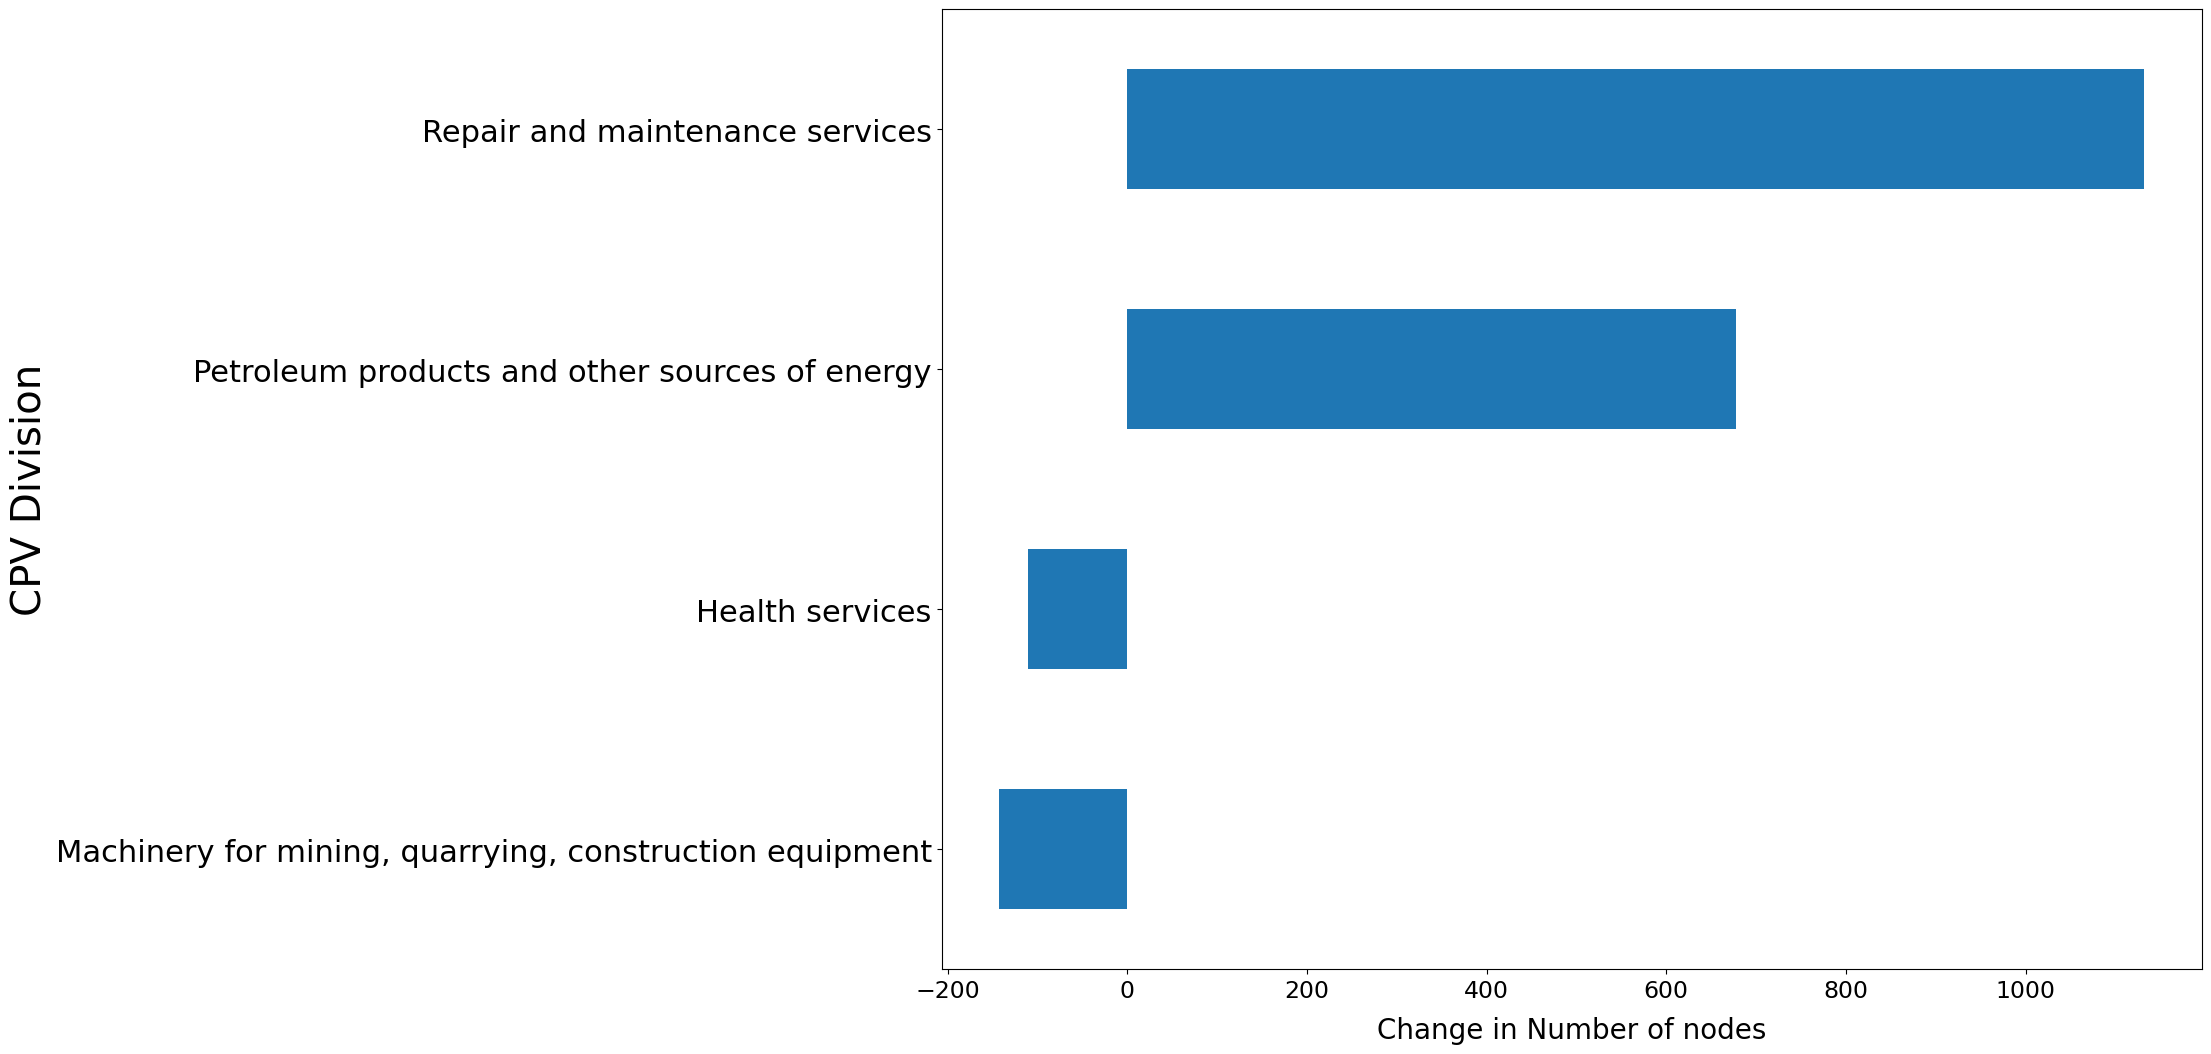

In [70]:
# Figure 1: Number of nodes
x = desc[desc['market'].isin(['50', '09', '43', '85'])]
plot = 'Number of nodes'

pt = pd.pivot_table(x, values=plot, index='market_str', columns='time')
pt['change'] = pt['after'] - pt['before']
pt = pt.rename(columns={'change': plot})
pt = pt[[plot]]

# Sort the DataFrame by the values in the column
pt = pt.sort_values(by=plot, ascending=True)  # Change to ascending=False for descending order

# create a horizontal bar chart
fig, ax = plt.subplots(figsize=(18, 12))  # set the figure size
pt.plot.barh(legend=None, ax=ax)  # use horizontal bar chart

# set the x and y axis labels
ax.set_xlabel(f'Change in {plot}', labelpad=10, fontsize=20)  # x-axis label
ax.set_ylabel('CPV Division', fontsize=29)  # y-axis label

# control the font size of the tick labels (axis labels)
ax.tick_params(axis='x', labelsize=17)  # x-axis tick labels
ax.tick_params(axis='y', labelsize=22)  # y-axis tick labels

# adjust the subplot spacing and margins
plt.subplots_adjust(bottom=0.1, left=0.2, right=0.9, top=0.9)

# save and show the chart
plt.savefig(f'Sector_{plot}.jpeg', dpi=300, bbox_inches='tight')
plt.show()
    

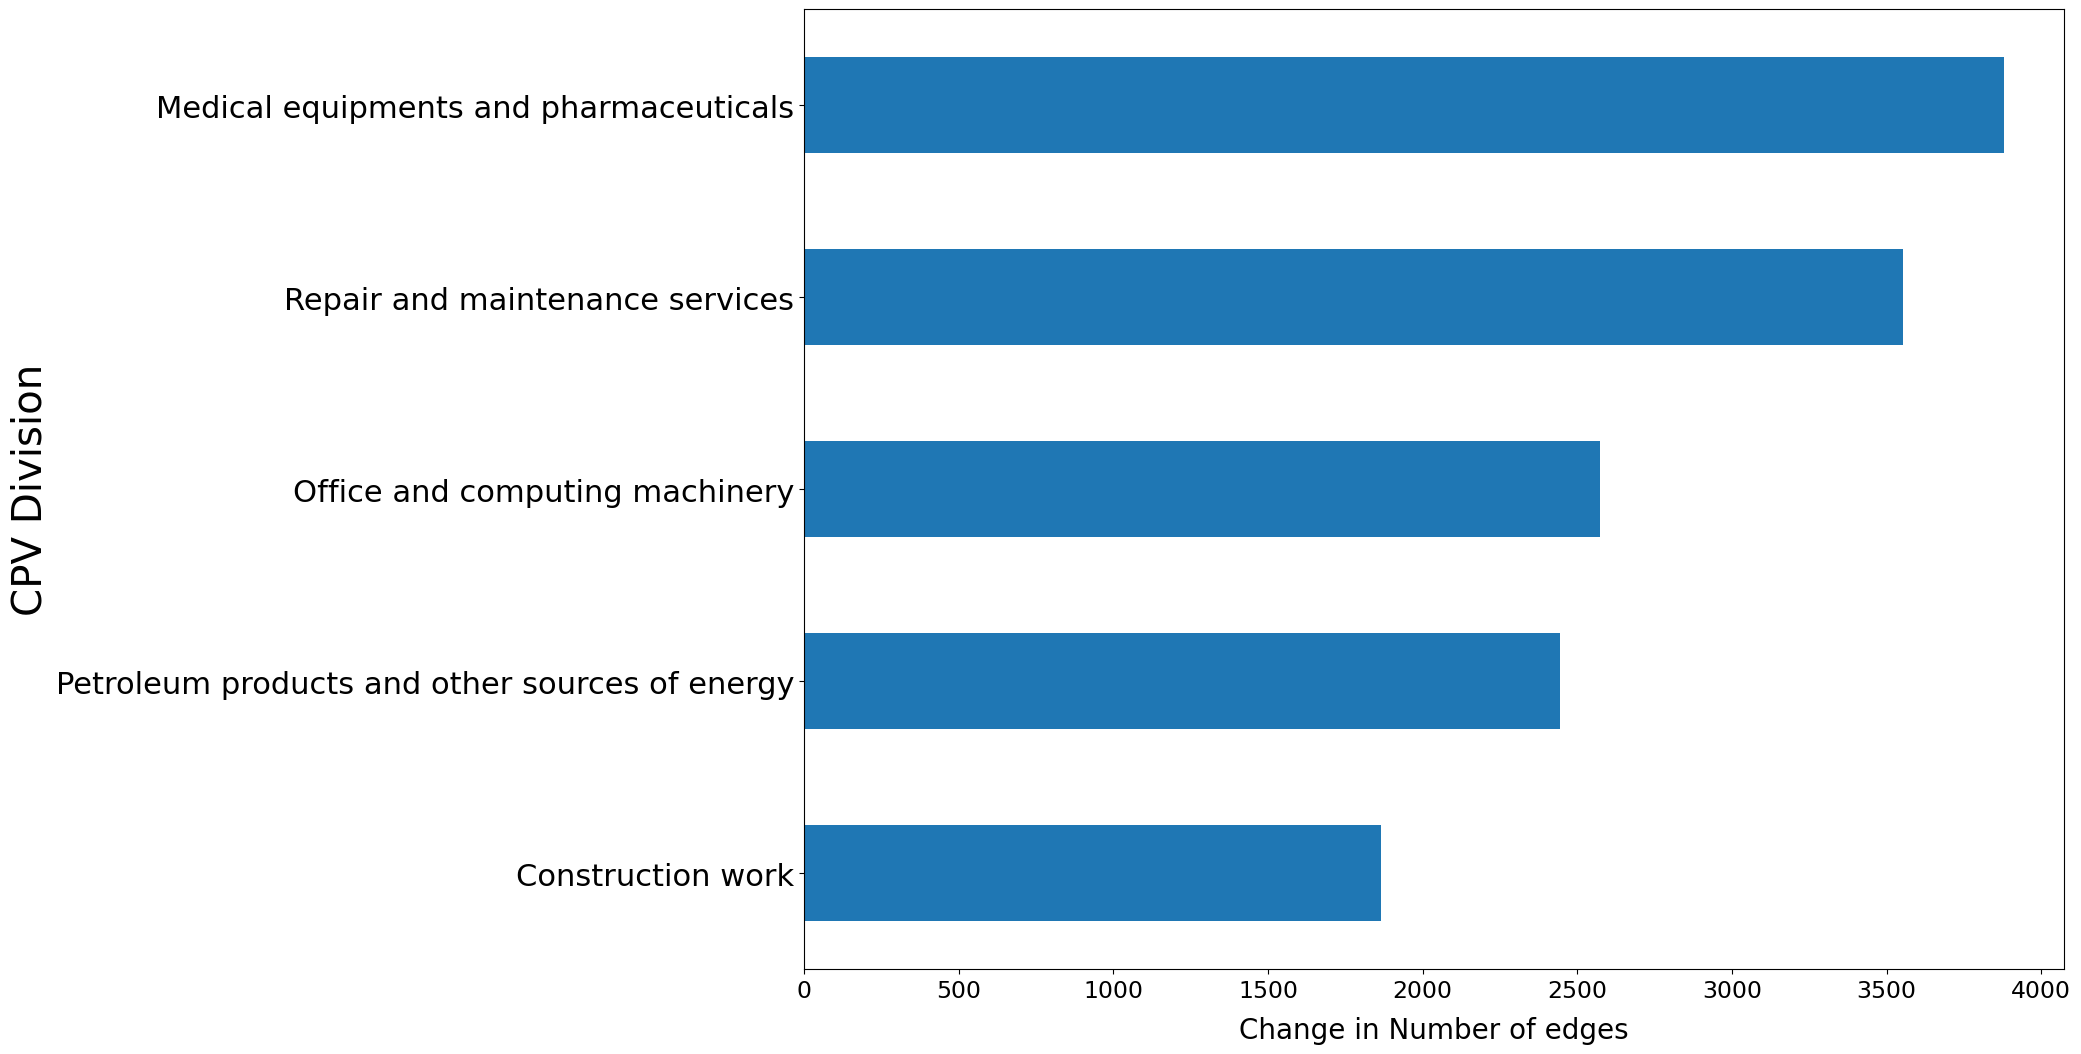

In [71]:
# Figure 2: Number of edges
# x = desc[desc['market'].isin(['33','50','43'])]
x = desc[desc['market'].isin(['33','50','30','09','45'])]
plot = 'Number of edges'

pt = pd.pivot_table(x, values=plot, index='market_str', columns='time')
pt['change'] = pt['after'] - pt['before']
pt = pt.rename(columns={'change': plot})
pt = pt[[plot]]

# Sort the DataFrame by the values in the column
pt = pt.sort_values(by=plot, ascending=True)  # Change to ascending=False for descending order

# create a horizontal bar chart
fig, ax = plt.subplots(figsize=(18, 12))  # set the figure size
pt.plot.barh(legend=None, ax=ax)  # use horizontal bar chart

# set the x and y axis labels
ax.set_xlabel(f'Change in {plot}', labelpad=10, fontsize=20)  # x-axis label
ax.set_ylabel('CPV Division', fontsize=29)  # y-axis label

# control the font size of the tick labels (axis labels)
ax.tick_params(axis='x', labelsize=17)  # x-axis tick labels
ax.tick_params(axis='y', labelsize=22)  # y-axis tick labels

# adjust the subplot spacing and margins
plt.subplots_adjust(bottom=0.1, left=0.2, right=0.9, top=0.9)

# save and show the chart
plt.savefig(f'Sector_{plot}.jpeg', dpi=300, bbox_inches='tight')
plt.show()
    

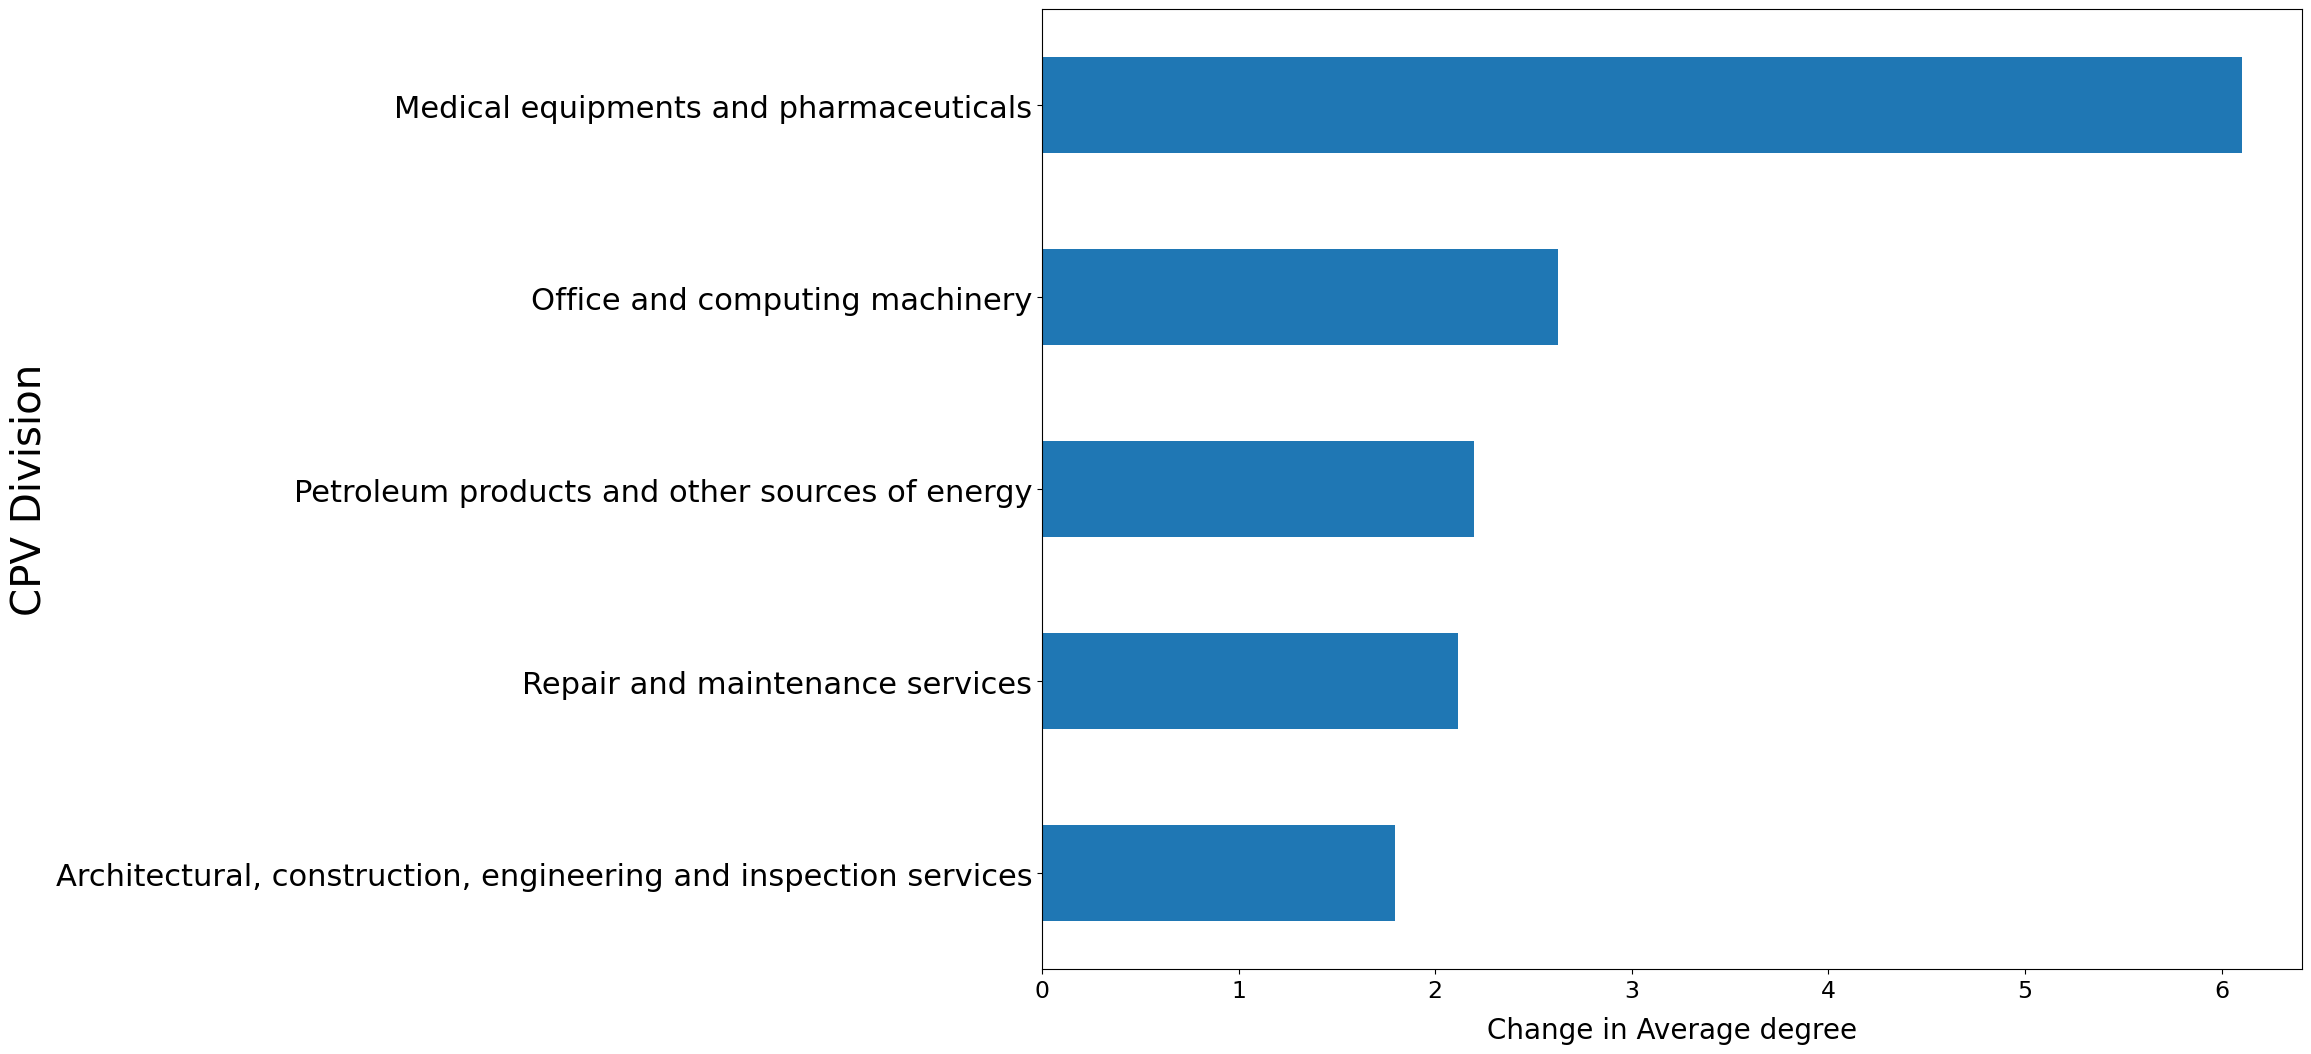

In [72]:
# Figure 3: Average degree
x = desc[desc['market'].isin(['33','30','09','50','71'])]
plot = 'Average degree'

pt = pd.pivot_table(x, values=plot, index='market_str', columns='time')
pt['change'] = pt['after'] - pt['before']
pt = pt.rename(columns={'change': plot})
pt = pt[[plot]]

# Sort the DataFrame by the values in the column
pt = pt.sort_values(by=plot, ascending=True)  # Change to ascending=False for descending order

# create a horizontal bar chart
fig, ax = plt.subplots(figsize=(18, 12))  # set the figure size
pt.plot.barh(legend=None, ax=ax)  # use horizontal bar chart

# set the x and y axis labels
ax.set_xlabel(f'Change in {plot}', labelpad=10, fontsize=20)  # x-axis label
ax.set_ylabel('CPV Division', fontsize=29)  # y-axis label

# control the font size of the tick labels (axis labels)
ax.tick_params(axis='x', labelsize=17)  # x-axis tick labels
ax.tick_params(axis='y', labelsize=22)  # y-axis tick labels

# adjust the subplot spacing and margins
plt.subplots_adjust(bottom=0.1, left=0.2, right=0.9, top=0.9)

# save and show the chart
plt.savefig(f'Sector_{plot}.jpeg', dpi=300, bbox_inches='tight')
plt.show()
    

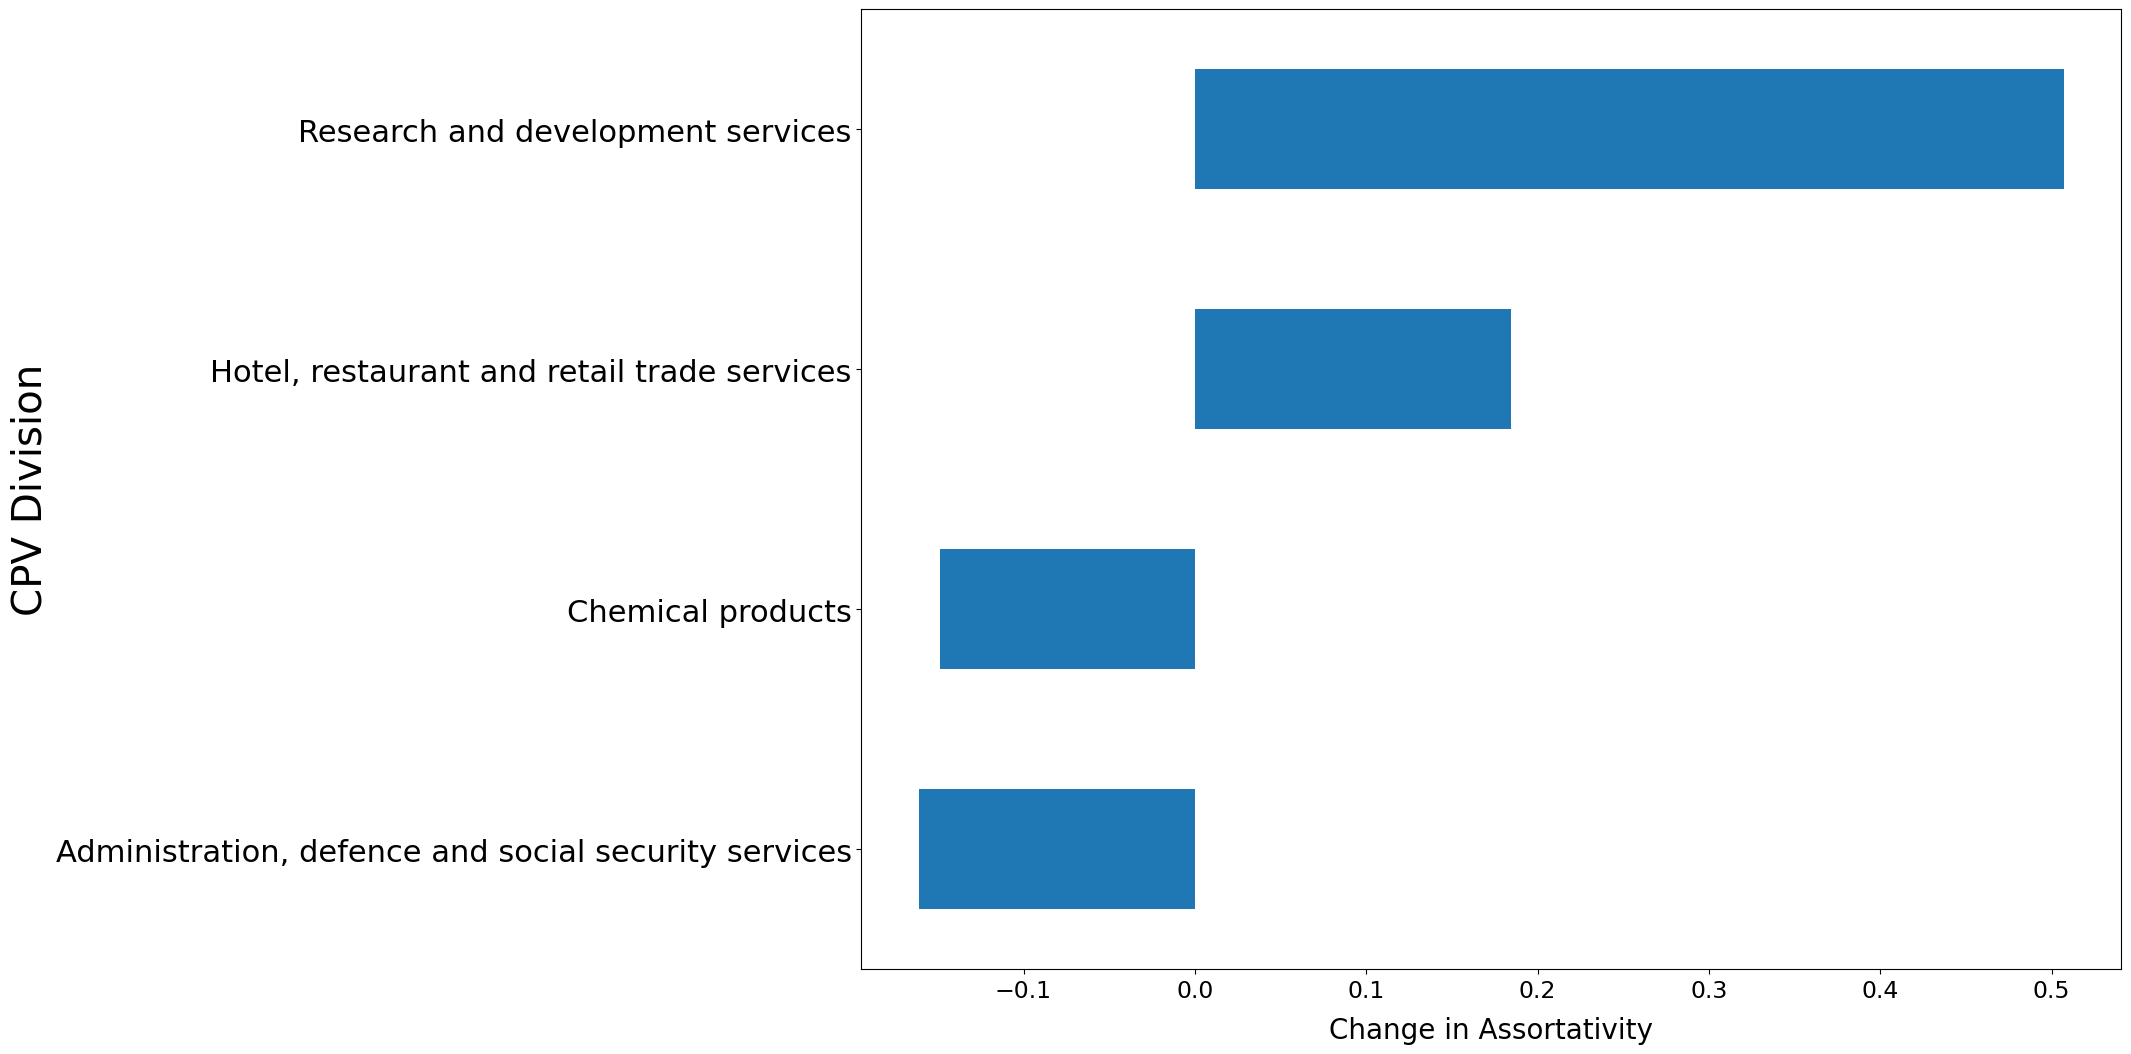

In [73]:
# Figure 4: Assortativity
x = desc[desc['market'].isin(['73','55','75','24'])]
plot = 'Assortativity'

pt = pd.pivot_table(x, values=plot, index='market_str', columns='time')
pt['change'] = pt['after'] - pt['before']
pt = pt.rename(columns={'change': plot})
pt = pt[[plot]]

# Sort the DataFrame by the values in the column
pt = pt.sort_values(by=plot, ascending=True)  # Change to ascending=False for descending order

# create a horizontal bar chart
fig, ax = plt.subplots(figsize=(18, 12))  # set the figure size
pt.plot.barh(legend=None, ax=ax)  # use horizontal bar chart

# set the x and y axis labels
ax.set_xlabel(f'Change in {plot}', labelpad=10, fontsize=20)  # x-axis label
ax.set_ylabel('CPV Division', fontsize=29)  # y-axis label

# control the font size of the tick labels (axis labels)
ax.tick_params(axis='x', labelsize=17)  # x-axis tick labels
ax.tick_params(axis='y', labelsize=22)  # y-axis tick labels

# adjust the subplot spacing and margins
plt.subplots_adjust(bottom=0.1, left=0.2, right=0.9, top=0.9)

# save and show the chart
plt.savefig(f'Sector_{plot}.jpeg', dpi=300, bbox_inches='tight')
plt.show()
    

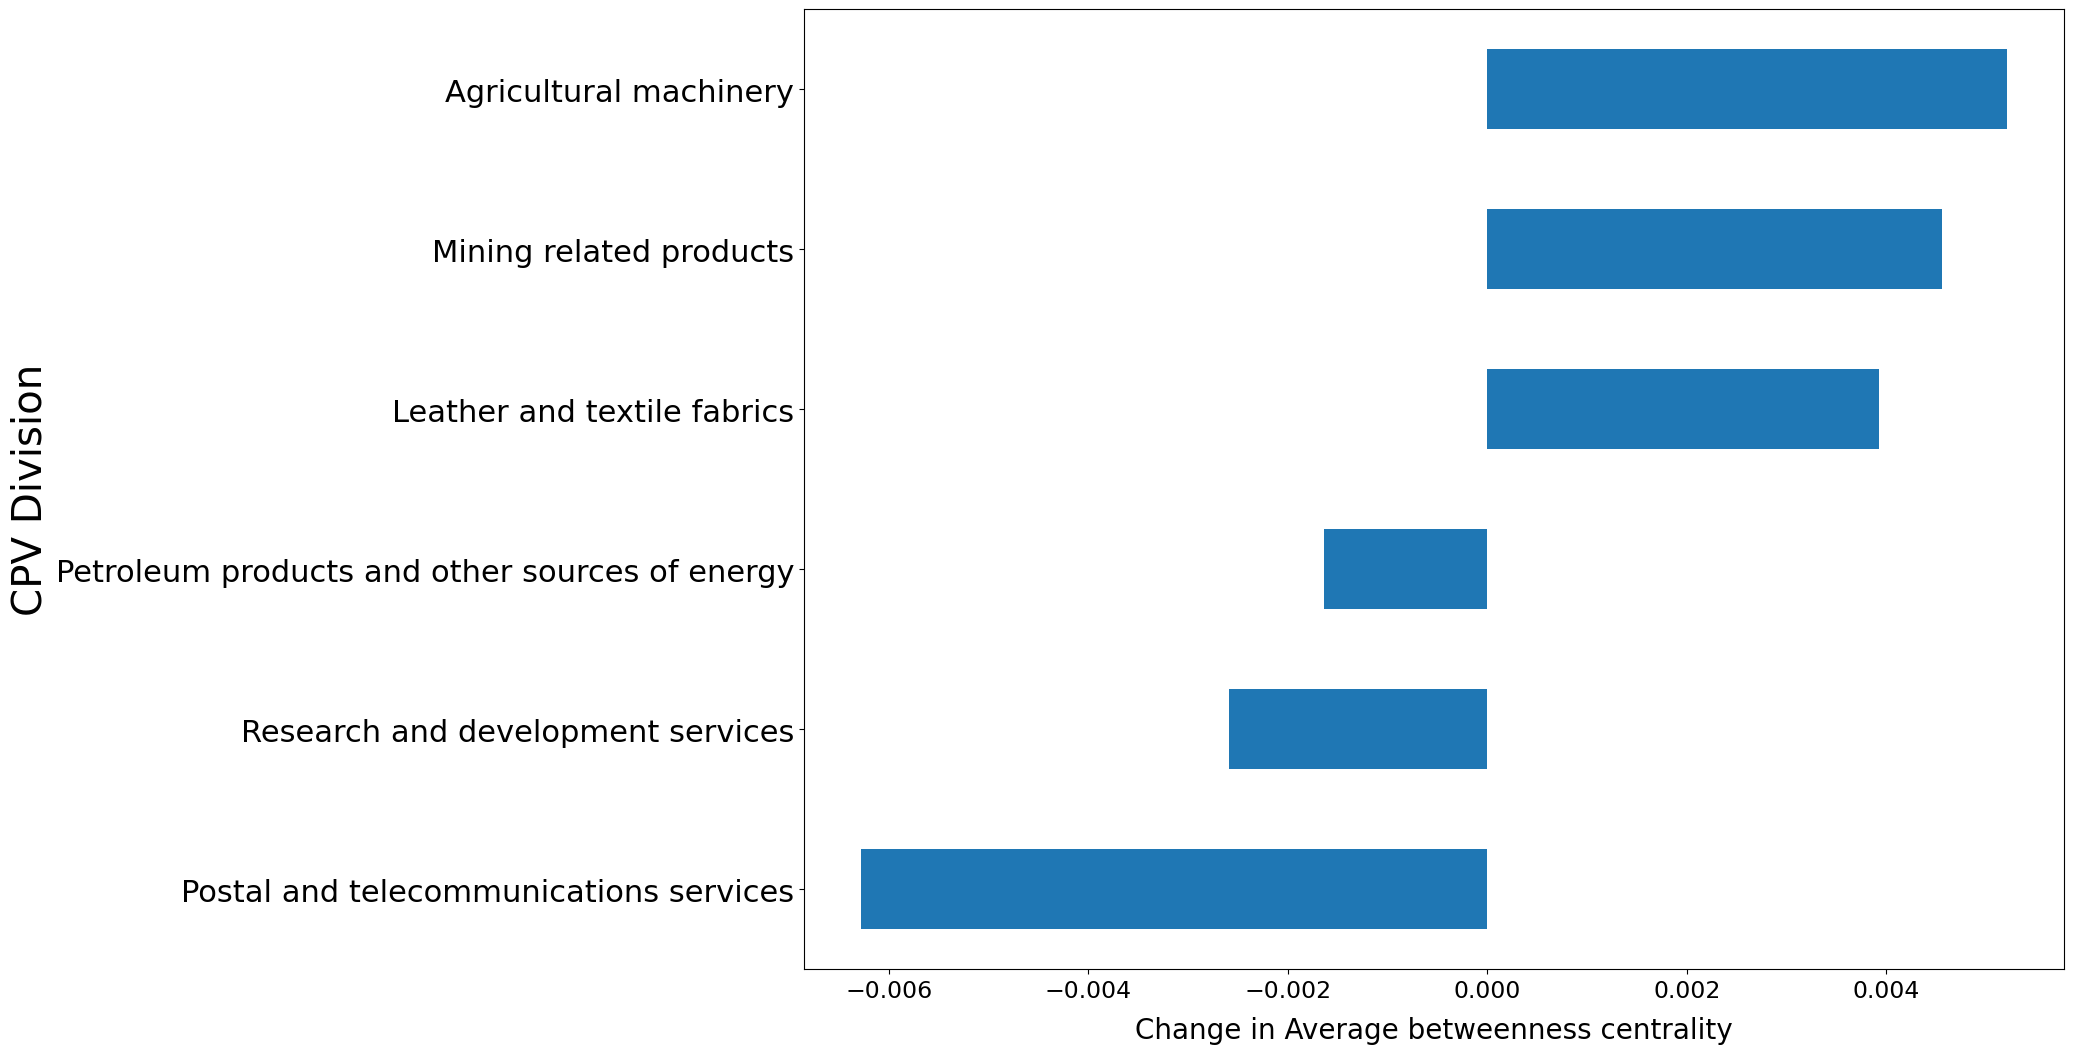

In [82]:
# Figure 5: Average betweenness centrality
x = desc[desc['market'].isin(['64','16','19','73','09','14'])]
# x = desc[(desc['market_str'] != 'Medical equipments and pharmaceuticals')] 

plot = 'Average betweenness centrality'

pt = pd.pivot_table(x, values=plot, index='market_str', columns='time')
pt['change'] = pt['after'] - pt['before']
pt = pt.rename(columns={'change': plot})
pt = pt[[plot]]

# Sort the DataFrame by the values in the column
pt = pt.sort_values(by=plot, ascending=True)  # Change to ascending=False for descending order

# create a horizontal bar chart
fig, ax = plt.subplots(figsize=(18, 12))  # set the figure size
pt.plot.barh(legend=None, ax=ax)  # use horizontal bar chart

# set the x and y axis labels
ax.set_xlabel(f'Change in {plot}', labelpad=10, fontsize=20)  # x-axis label
ax.set_ylabel('CPV Division', fontsize=29)  # y-axis label

# control the font size of the tick labels (axis labels)
ax.tick_params(axis='x', labelsize=17)  # x-axis tick labels
ax.tick_params(axis='y', labelsize=22)  # y-axis tick labels

# adjust the subplot spacing and margins
plt.subplots_adjust(bottom=0.1, left=0.2, right=0.9, top=0.9)

# save and show the chart
plt.savefig(f'Sector_{plot}.jpeg', dpi=300, bbox_inches='tight')
plt.show()
    

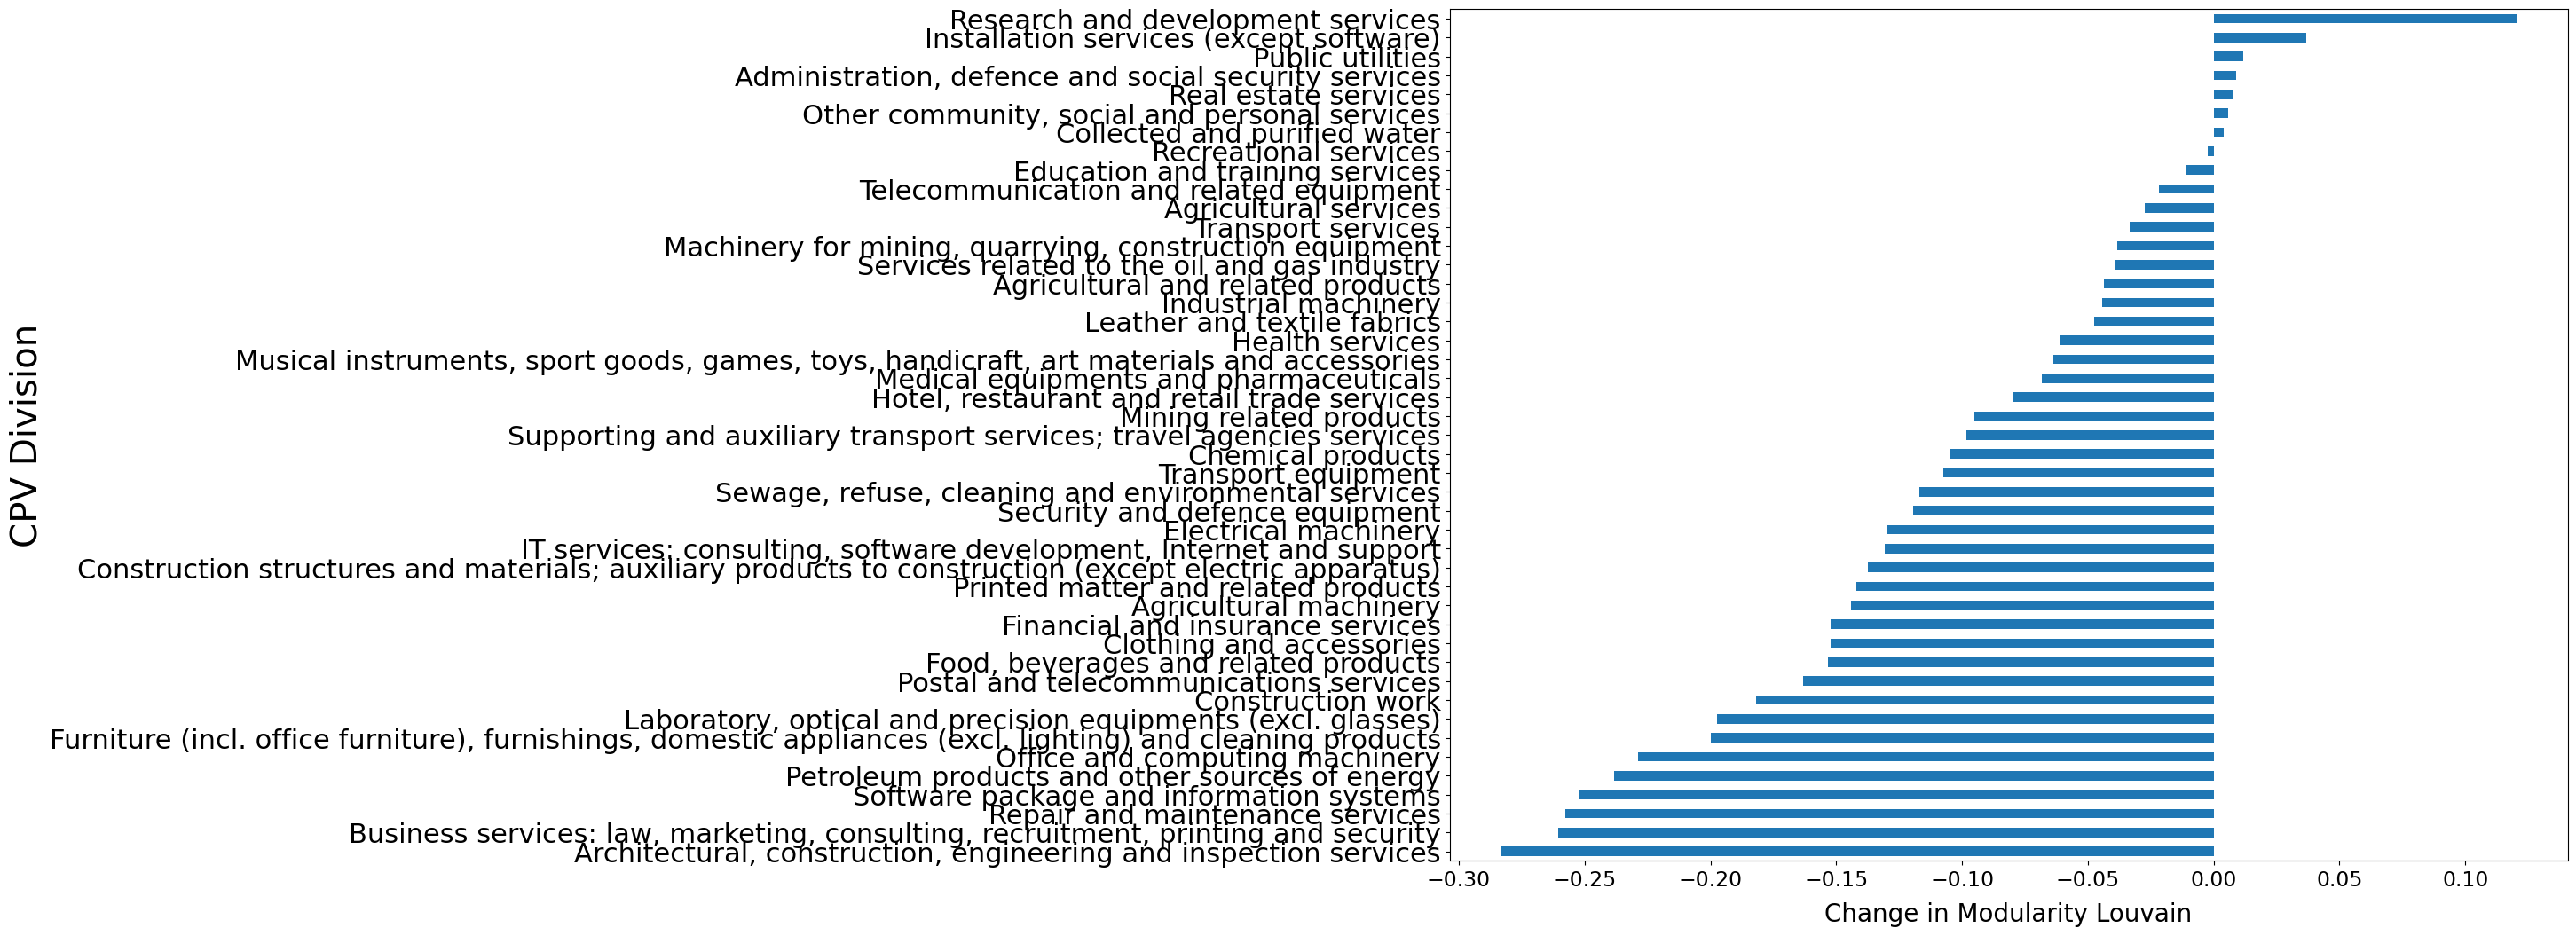

In [83]:
# Figure 6: Modularity Louvain
x = desc[desc['market'].isin(['71','79','73','51'])]

plot = 'Modularity Louvain'

pt = pd.pivot_table(x, values=plot, index='market_str', columns='time')
pt['change'] = pt['after'] - pt['before']
pt = pt.rename(columns={'change': plot})
pt = pt[[plot]]

# Sort the DataFrame by the values in the column
pt = pt.sort_values(by=plot, ascending=True)  # Change to ascending=False for descending order

# create a horizontal bar chart
fig, ax = plt.subplots(figsize=(18, 12))  # set the figure size
pt.plot.barh(legend=None, ax=ax)  # use horizontal bar chart

# set the x and y axis labels
ax.set_xlabel(f'Change in {plot}', labelpad=10, fontsize=20)  # x-axis label
ax.set_ylabel('CPV Division', fontsize=29)  # y-axis label

# control the font size of the tick labels (axis labels)
ax.tick_params(axis='x', labelsize=17)  # x-axis tick labels
ax.tick_params(axis='y', labelsize=22)  # y-axis tick labels

# adjust the subplot spacing and margins
plt.subplots_adjust(bottom=0.1, left=0.2, right=0.9, top=0.9)

# save and show the chart
plt.savefig(f'Sector_{plot}.jpeg', dpi=300, bbox_inches='tight')
plt.show()
    

In [ ]:
# # Figure 3: '33','50','43'
# x = desc[desc['market'].isin(['33','50','43'])]
# plot = 'Average degree'

# pt = pd.pivot_table(x, values=plot, index='market_str', columns='time')
# pt['change'] = pt['after'] - pt['before']
# pt = pt.rename(columns={'change': plot})
# pt = pt[[plot]]

# # create a horizontal bar chart
# fig, ax = plt.subplots(figsize=(18, 12))  # set the figure size
# pt.plot.barh(legend=None, ax=ax)  # use horizontal bar chart

# # set the x and y axis labels
# ax.set_xlabel(f'Change in {plot}', labelpad=10, fontsize=20)  # x-axis label
# ax.set_ylabel('CPV Division', fontsize=29)  # y-axis label

# # control the font size of the tick labels (axis labels)
# ax.tick_params(axis='x', labelsize=17)  # x-axis tick labels
# ax.tick_params(axis='y', labelsize=20)  # y-axis tick labels

# # adjust the subplot spacing and margins
# plt.subplots_adjust(bottom=0.1, left=0.2, right=0.9, top=0.9)

# # save and show the chart
# # plt.savefig(f'Sector_{plot}.jpeg', dpi=300, bbox_inches='tight')
# plt.show()
    

# Scrap

### Plot Graph

In [ ]:
betweenness_centrality = nx.betweenness_centrality(Gc)
node_sizes = [v * 1500 for v in betweenness_centrality.values()]

source_nodes = [edge[0] for edge in Gc.edges()]

color_map = {}
for node in Gc.nodes():
    if node in source_nodes:
        color_map[node] = 'blue'
    else:
        color_map[node] = 'orange'


edge_colors = [Gc[u][v]['cri'] for u, v in Gc.edges()]

# Giving the count more importance int he layout 
# for u, v, d in Gc.edges(data=True):
#     d['weight'] = d.get('count', 1)

plt.figure(figsize=(12,12))
pos = nx.fruchterman_reingold_layout(Gc, scale=200, iterations=10, k=200, weight='count'*100)
# pos = nx.kamada_kawai_layout(G, scale=200, center=None, dim=2, weight='count'*100)

nx.draw_networkx_nodes(Gc, pos, node_size=node_sizes, node_color=[color_map[node] for node in Gc.nodes()], node_shape='o')
nx.draw_networkx_edges(Gc, pos, edge_color=edge_colors, edge_cmap=plt.cm.coolwarm)
#  coolwarm - blue low to red high
# viridis
# nx.draw_networkx_labels(G, pos, font_size=12)

plt.axis('off')
plt.box(False)
plt.show()
# plt.savefig("C:\\Ourfolders\\Aly\\MK_WB\\output\\figures\\Network_figures\\network_45_MK002.png", dpi=300, bbox_inches='tight')


## Community detection

In [ ]:
# Calculate the modularity of graph object G

modularity = nx.algorithms.community.modularity_max.greedy_modularity_communities(Gc)

# Get modularity of graph using this partiion
nx.algorithms.community.modularity(Gc, modularity)

# modularity (slower)
# modularity = nx.algorithms.community.modularity_max.naive_greedy_modularity_communities(Gc)

# K clique
from networkx.algorithms.community import k_clique_communities
modularity = list(k_clique_communities(Gc, 4))
modularity

# Louvain Community Detection
modularity = nx.algorithms.community.louvain_communities(G, weight = 'cri',seed=123)

# check girvan_newman - uses centrality measures
# https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.centrality.girvan_newman.html#networkx.algorithms.community.centrality.girvan_newman
from networkx import edge_betweenness_centrality as betweenness
from networkx.algorithms.community import girvan_newman

def most_central_edge(G):
    centrality = betweenness(G, weight="cri")
    return max(centrality, key=centrality.get)

comp = girvan_newman(Gc, most_valuable_edge=most_central_edge)

tuple_list = tuple(sorted(c) for c in next(comp))
modularity = [frozenset(t) for t in tuple_list]
nx.algorithms.community.modularity(Gc, modularity)



In [ ]:
# Calculate the modularity of graph object G
modularity = nx.algorithms.community.modularity_max.greedy_modularity_communities(Gc)

# Assign different colors to nodes based on their modularity group
colors = [i for i, group in enumerate(modularity)]

color_map = []
for node in Gc.nodes:
    for i, group in enumerate(modularity):
        if node in group:
            color_map.append(i)
            break

nx.draw_networkx_nodes(Gc, pos, node_size=node_sizes, node_color=color_map, node_shape='o')
nx.draw_networkx_edges(Gc, pos, edge_color=edge_colors, edge_cmap=plt.cm.coolwarm)

plt.axis('off')
plt.box(False)
plt.show()
            


### 1st attempt  ++  more options in cells below

In [ ]:
edge_colors = [G[u][v]['cri'] for u, v in G.edges()]

node_sizes = [v * 5000 for v in betweenness_centrality.values()]


# create a dictionary to specify node colors
source_nodes = [edge[0] for edge in G.edges()]

color_map = {}
for node in G.nodes():
    if node in source_nodes:
        color_map[node] = 'blue'
    else:
        color_map[node] = 'green'

pos = nx.fruchterman_reingold_layout(G, scale=5 , iterations = 2, k = 5)

nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=[color_map[node] for node in G.nodes()])

nx.draw_networkx_edges(G, pos, edge_color=edge_colors, edge_cmap=plt.cm.Reds)

plt.show()

In [ ]:
edge_colors = [G[u][v]['cri'] for u, v in G.edges()]

node_sizes = [v * 5000 for v in betweenness_centrality.values()]

source_nodes = [edge[0] for edge in G.edges()]

color_map = {}
for node in G.nodes():
    if node in source_nodes:
        color_map[node] = 'blue'
    else:
        color_map[node] = 'green'

plt.figure(figsize=(12,12))
pos = nx.fruchterman_reingold_layout(G, scale=10, iterations=2, k=5)

nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=[color_map[node] for node in G.nodes()], node_shape='o')
nx.draw_networkx_edges(G, pos, edge_color=edge_colors, edge_cmap=plt.cm.viridis)
# nx.draw_networkx_labels(G, pos, font_size=12)

plt.axis('off')
plt.box(False)
# plt.show()
plt.savefig("C:\\Ourfolders\\Aly\\MK_WB\\output\\figures\\Network_figures\\graph.png", dpi=300, bbox_inches='tight')


In [ ]:
# pos = nx.spring_layout(G)

edge_colors = [G[u][v]['cri'] for u, v in G.edges()]

# threshold = 2
# normalizer = matplotlib.colors.Normalize(vmin=min(edge_colors), vmax=max(edge_colors))
# edge_colors_normalized = normalizer(edge_colors)

# threshold_edge_colors = [color if cri >= threshold else 'red' for cri, color in zip(edge_colors, edge_colors_normalized)]


node_sizes = [v * 5000 for v in betweenness_centrality.values()]

# create a dictionary to specify node colors
source_nodes = [edge[0] for edge in G.edges()]

color_map = {}
for node in G.nodes():
    if node in source_nodes:
        color_map[node] = 'blue'
    else:
        color_map[node] = 'green'

pos = nx.fruchterman_reingold_layout(G, scale=5 , iterations = 2, k = 5)

# nx.draw_networkx(G, pos, with_labels=False , node_size=node_sizes)
# nx.draw_networkx_nodes(G, pos, node_size=node_sizes)
# nx.draw_networkx_edges(G, pos, edge_color='gray')


# nx.draw_networkx_nodes(G, pos, node_size=node_sizes , nodelist=G.nodes(),node_color=list(color_map.values()), with_labels=False)
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=[color_map[node] for node in G.nodes()])

# nx.draw_networkx_edges(G, pos, edge_color=edge_colors, edge_cmap=plt.cm.Reds)
# nx.draw_networkx_edges(G, pos, edge_color=edge_colors, edge_cmap=plt.cm.Greens_r, width=2, vmin=threshold)
nx.draw_networkx_edges(G, pos, edge_color=threshold_edge_colors, edge_cmap=plt.cm.Greens_r, width=0.5)

# plt.cm.Reds

plt.show()
# plt.savefig("C:\\Ourfolders\\Aly\\MK_WB\\output\\figures\\Network_figures\\graph.png", dpi=300, bbox_inches='tight')
